# Import and mount

In [3]:
from classes import RNNData, RNN, Vocab
from funcs import train, plot
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torchmetrics
from torch.utils.data import DataLoader

In [4]:
# connect to available device and set manual seed for reproducability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 42
torch.manual_seed(seed)

cpu


# Read data
Use 'raw' recipes

In [5]:
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
# read recipes
df = pd.read_pickle(f'../data/dataframes/all.pkl')
# plot size of recipes to determine max length
df['length'] = df['ingredients'].apply(len)

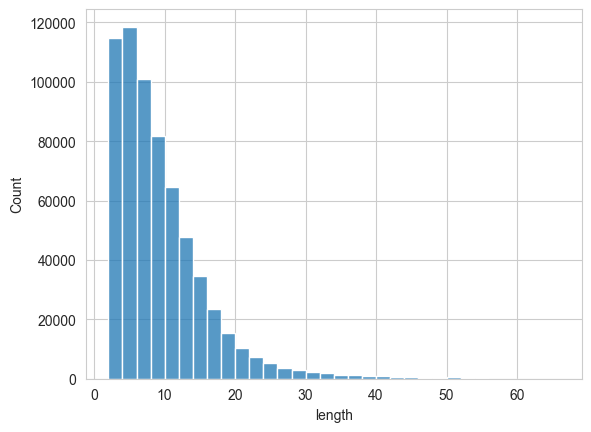

In [7]:
g = sns.histplot(df['length'], bins=32)

Based on the plot, we see that most recipes contain less than 20 ingredients. This is used as the maximum length. Shorter recipes are padded, while longer recipes are cut.

In [9]:
# build vocab
vocab = Vocab(f'../data/dataframes/ings.pkl')

In [10]:
# import recipes
df = pd.read_pickle(f'../data/dataframes/all.pkl')
# create a subset of 100,000 recipes because of time constraints
df = df.head(100000)
# subset recipes for hyperparameter optimisation
df = df.head(int(len(df)*0.1))

In [11]:
# set batch size and length to consider
batch_size, length = 1024, 20

# split into training and test sets
train_df, test_df = train_test_split(df, test_size=0.20, random_state = seed)

# read training data
train_data = RNNData(train_df, vocab, length)
train_iter = DataLoader(train_data, batch_size, shuffle=True, drop_last=True)

# read test data
test_data = RNNData(test_df, vocab, length)
test_iter = DataLoader(test_data, batch_size, shuffle=True, drop_last=True)

print('Training data'+'-'*50)
print(train_data)
print(len(train_data), 'recipes')

print('Test data'+'-'*50)
print(test_data)
print(len(test_data), 'recipes')

Training data--------------------------------------------------
0    [e300, maltodextrind, e171, e572, e464, starch...
1    [maltodextrind, e171, e572, e464, starch, inul...
2    [e171, e572, e464, starch, inulin, e300, malto...
3    [e572, e464, starch, inulin, e300, maltodextri...
4    [e464, starch, inulin, e300, maltodextrind, e1...
111789 recipes
Test data--------------------------------------------------
0    [e300, flavouring, e330, e202, e211, sodium-ci...
1    [flavouring, e330, e202, e211, sodium-citrate,...
2    [e330, e202, e211, sodium-citrate, e955, caffe...
3    [e202, e211, sodium-citrate, e955, caffeine, t...
4    [e211, sodium-citrate, e955, caffeine, taurine...
27898 recipes


In [12]:
# look at shape
x, y = next(iter(train_iter))
print(x.shape, y.shape)

torch.Size([1024, 20]) torch.Size([1024, 1])


1024 recipes in each batch, these recipes consists of 20 ingredients each.

In [ ]:
# look at examples from x and y
print('x' + '_'*100)
print(x[0])
print(', '.join([vocab.ings[int(i)] for i in x[0]]))

print('y' + '_'*100)
print(y[0])
print(', '.join([vocab.ings[int(i)] for i in y[0]]))

x____________________________________________________________________________________________________
tensor([  169,   399,   545,   593,   807,   810,   892,   906,   921,   969,
          975,  1092,  1294,  4547, 11572, 11584, 11599, 11678, 11702, 11729])
e516, e262ii, e251, ferment, e517, e927a, triglyceride, calcium-propionate-preservative, oleic-canola-oil, ham, croissant, e326, capric, maltrodextrin, cheese, corn syrup, caramel color, water, margarine, sugar
y____________________________________________________________________________________________________
tensor([11729])
sugar


The target (y) is the missing ingredient of the recipe (x). As all recipes are shuffled, every ingredient in the recipe is used as target once.

# Warmup net
Assigns 100 epochs and a learning rate of 0.1

In [ ]:
num_epochs, lr = 2, 1e-3
net = RNN(vocab)
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
num_epochs = 100

7.50 seconds per epoch on cuda


# Hyperparameter optimisation
Best model comes out to be:
*   Learning rate of 1e-3
*   8 embedding dimensions
*   128 hidden layers
*   1 one directional GRU layer

```
lr = 1e-3
# create model
net = RNN(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
```

## Learning rate
The model seems to converge well with a learning rate of 1e-3.
*   Train perplexity: 185
*   Test perplexity: 199

7.56 seconds per epoch on cuda


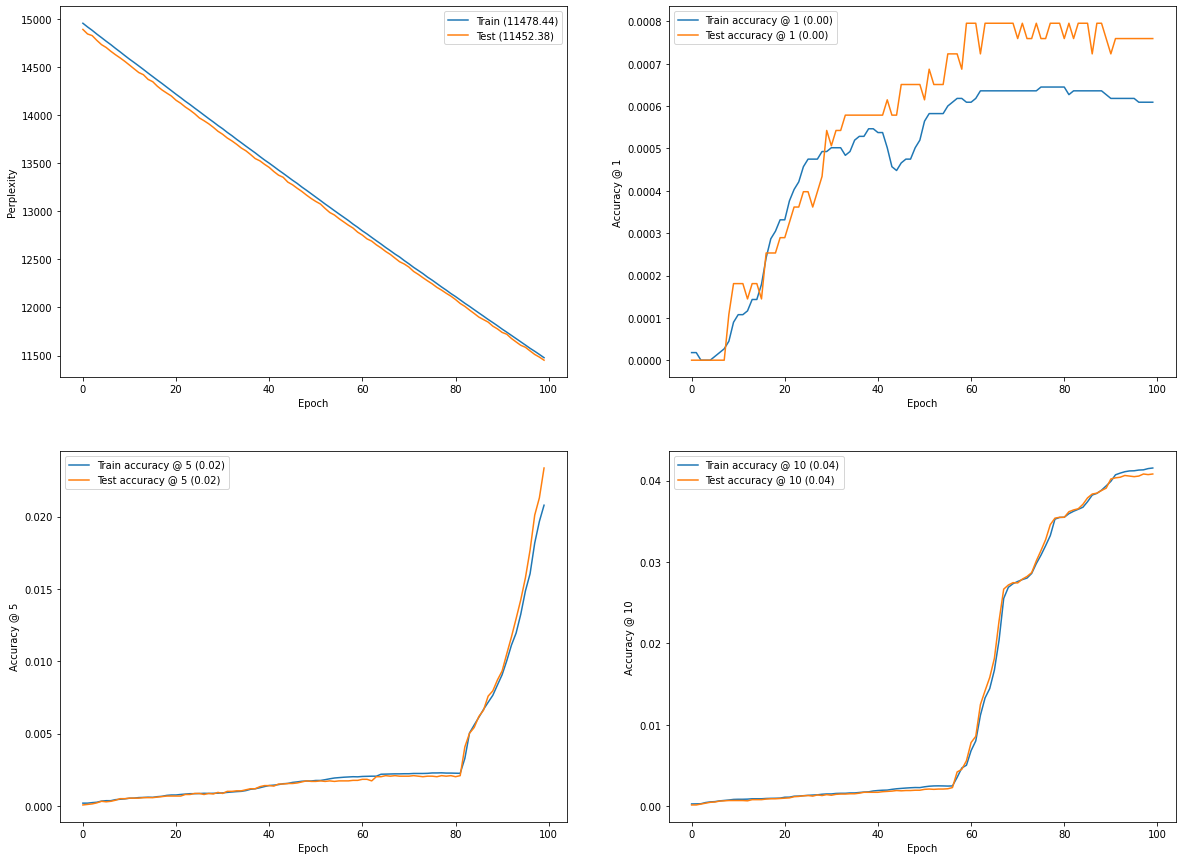

In [ ]:
# RNN trained with a learning rate of 1e-5
net = RNN(vocab)
# train and test model
num_epochs = 100
lr = 1e-5
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)

7.60 seconds per epoch on cuda


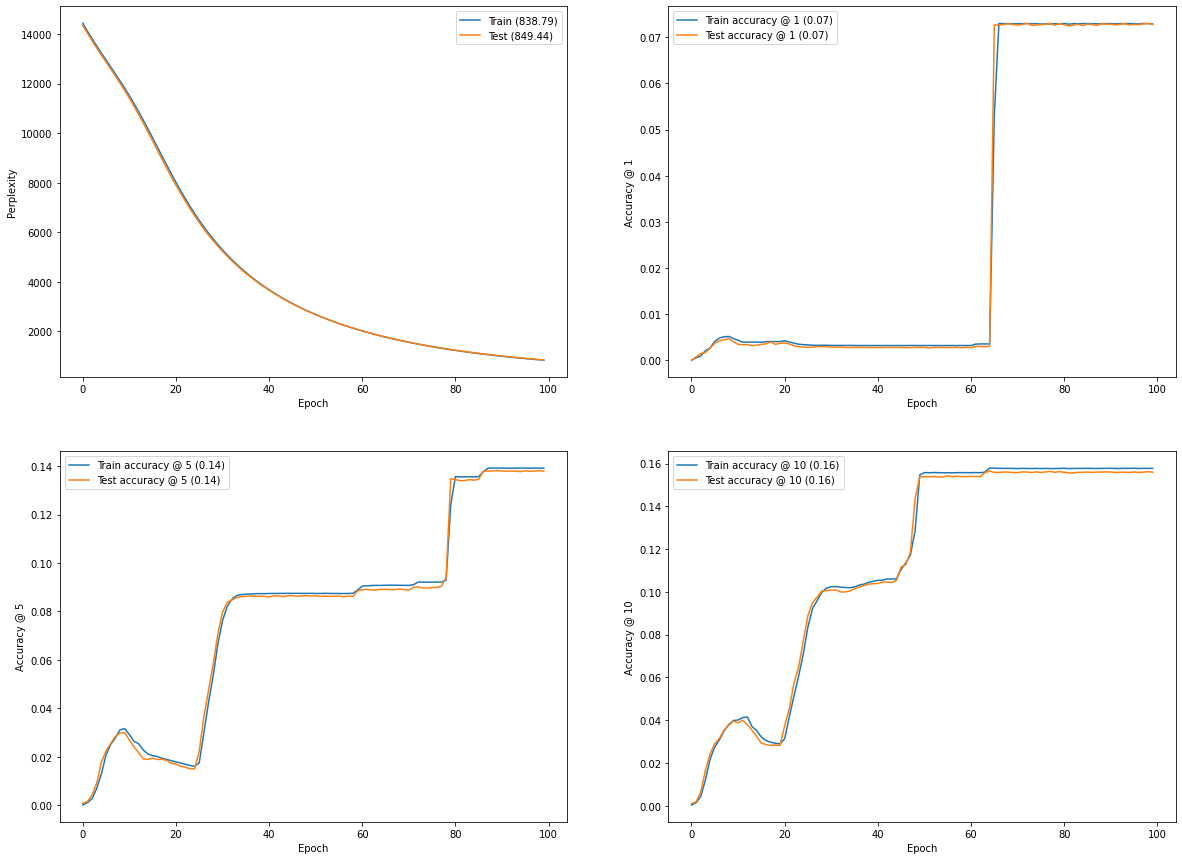

In [ ]:
# RNN trained with a learning rate of 1e-4
net = RNN(vocab)
# train and test model
num_epochs = 100
lr = 1e-4
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.68 seconds per epoch on cuda


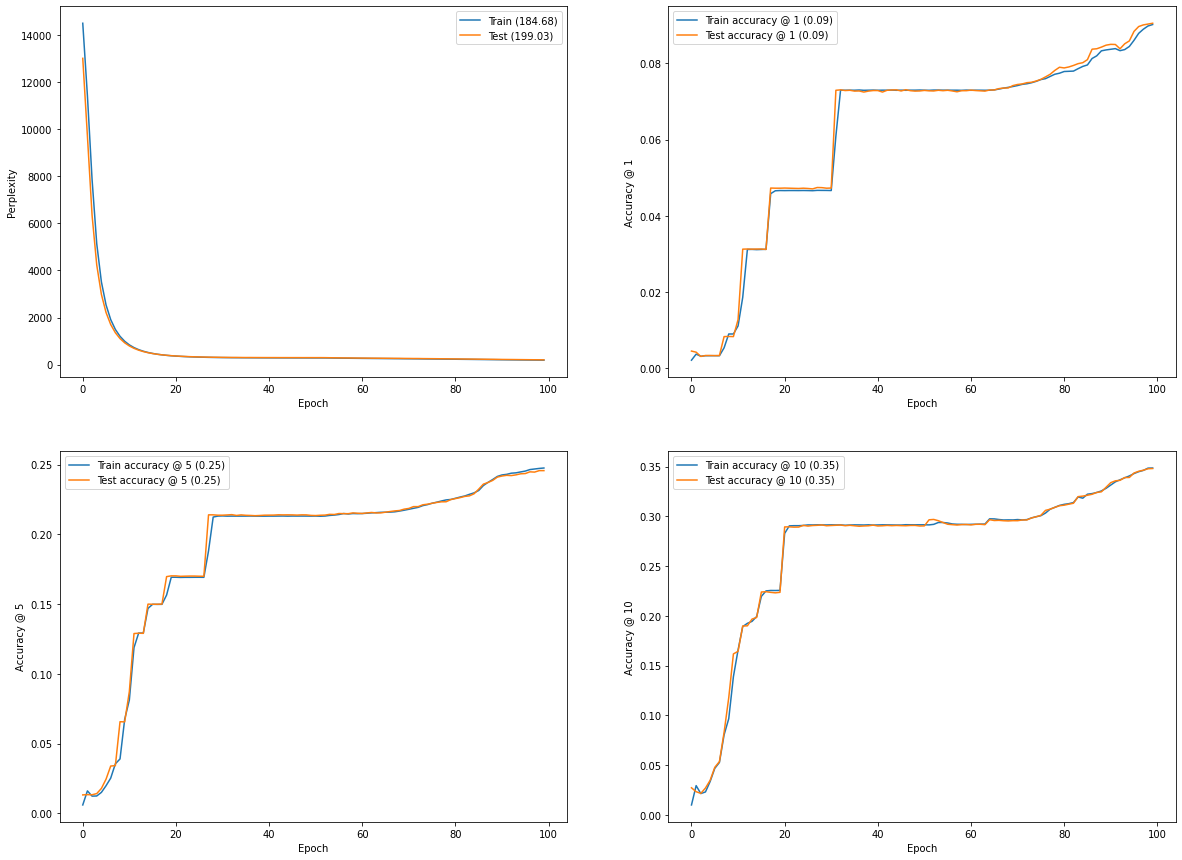

In [ ]:
# RNN trained with a learning rate of 1e-3
net = RNN(vocab)
# train and test model
num_epochs = 100
lr = 1e-3
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.59 seconds per epoch on cuda


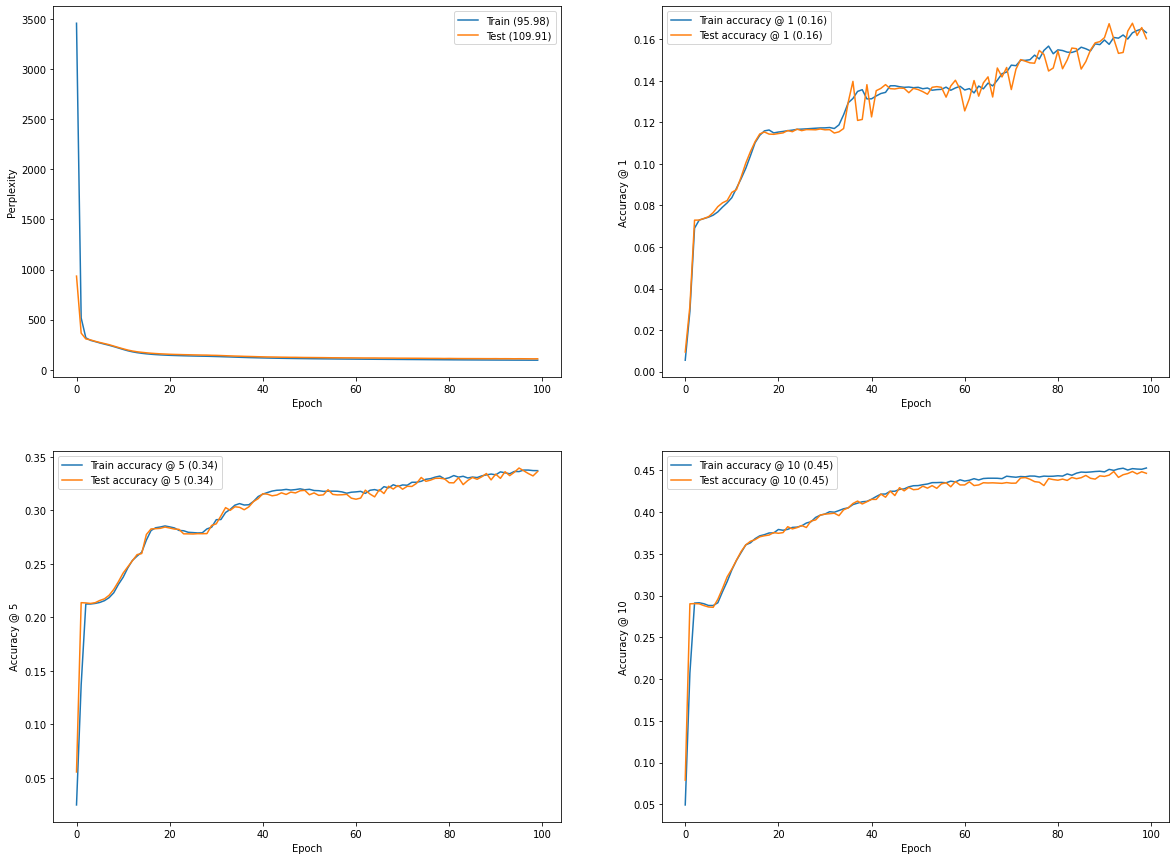

In [ ]:
# RNN trained with a learning rate of 1e-2
net = RNN(vocab)
# train and test model
num_epochs = 100
lr = 1e-2
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.59 seconds per epoch on cuda


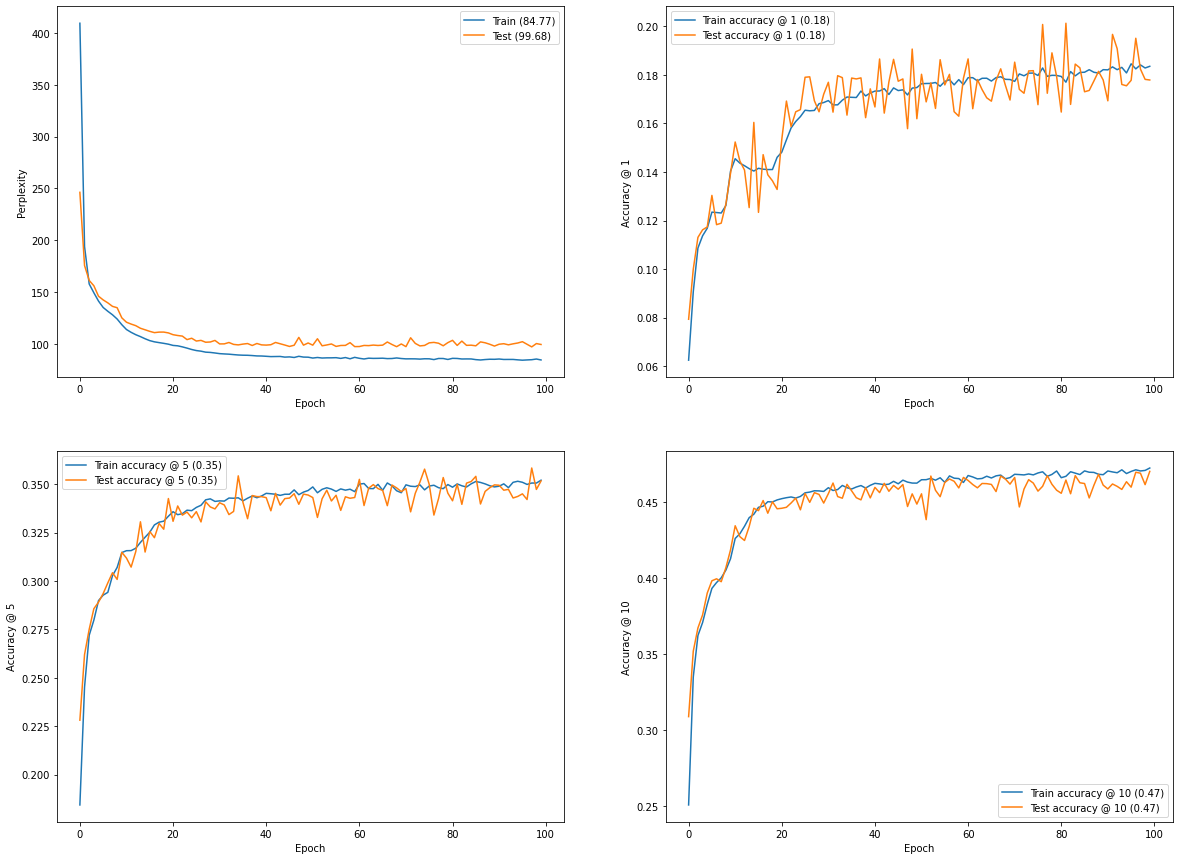

In [ ]:
# RNN trained with a learning rate of 1e-1
net = RNN(vocab)
# train and test model
num_epochs = 100
lr = 1e-1
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

## Embedding
The lowest train and test losses are found with 8 embedding dimensions. Larger embedding dimensions increase the perplexity.
*   Train perplexity: 81
*   Test perplexity: 100


In [ ]:
lr = 1e-3

7.77 seconds per epoch on cuda


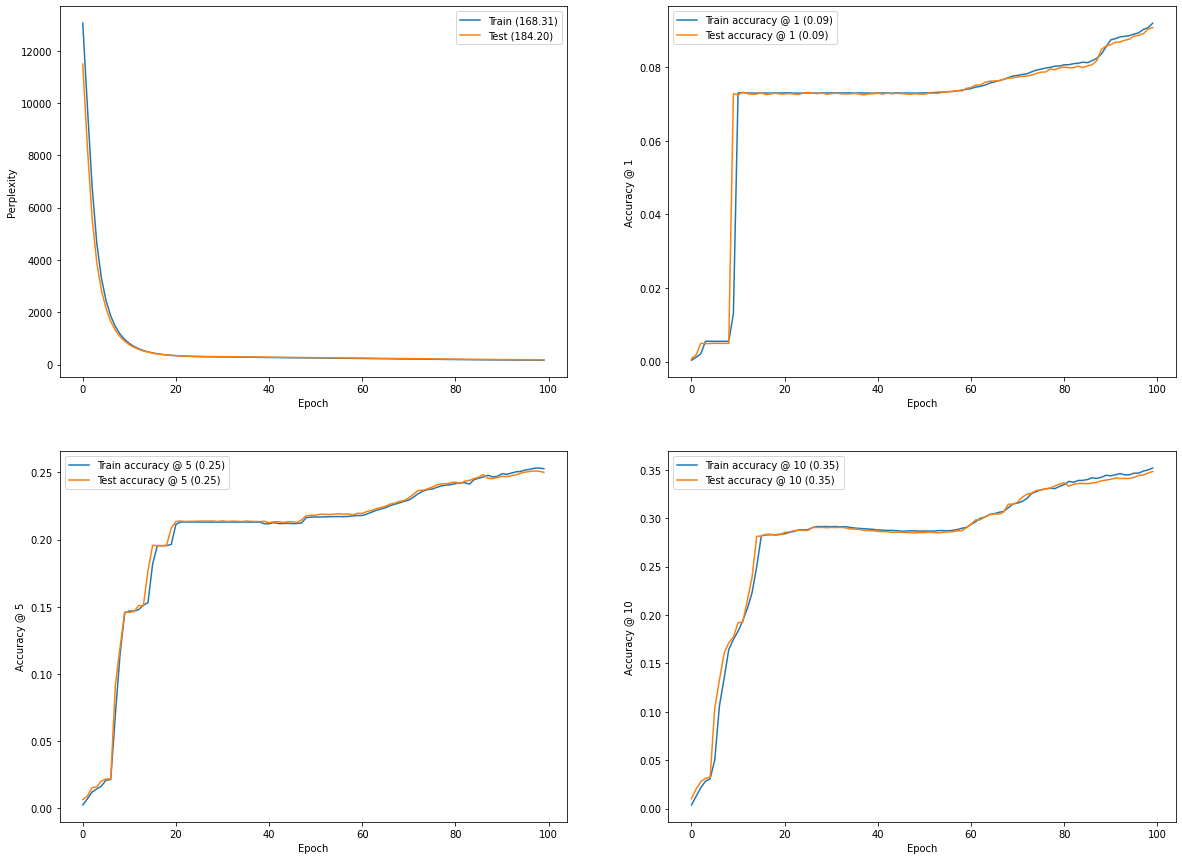

In [ ]:
# RNN trained with a learning rate of 1e-3 and embedding 8
net = RNN(vocab, embed_dim=8)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.52 seconds per epoch on cuda


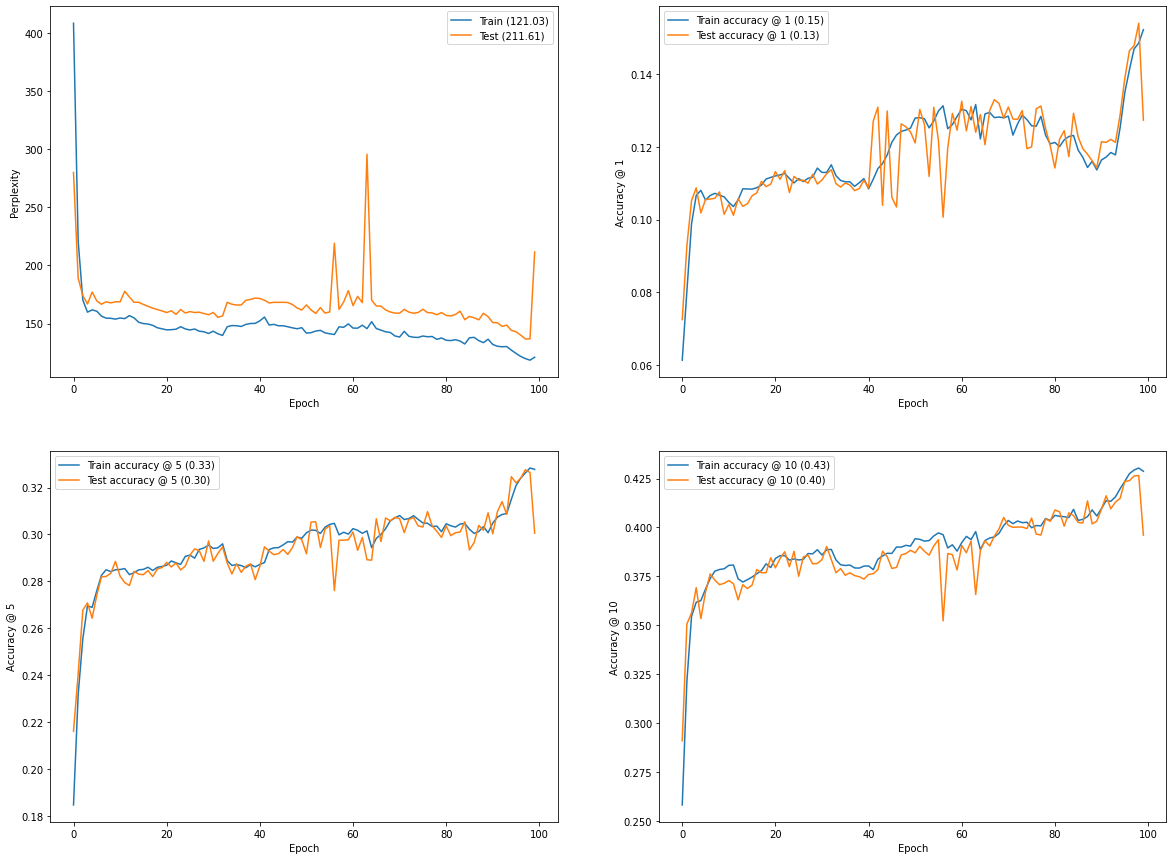

In [ ]:
# RNN trained with a learning rate of 1e-3 and embedding 16
net = RNN(vocab, embed_dim=16)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.50 seconds per epoch on cuda


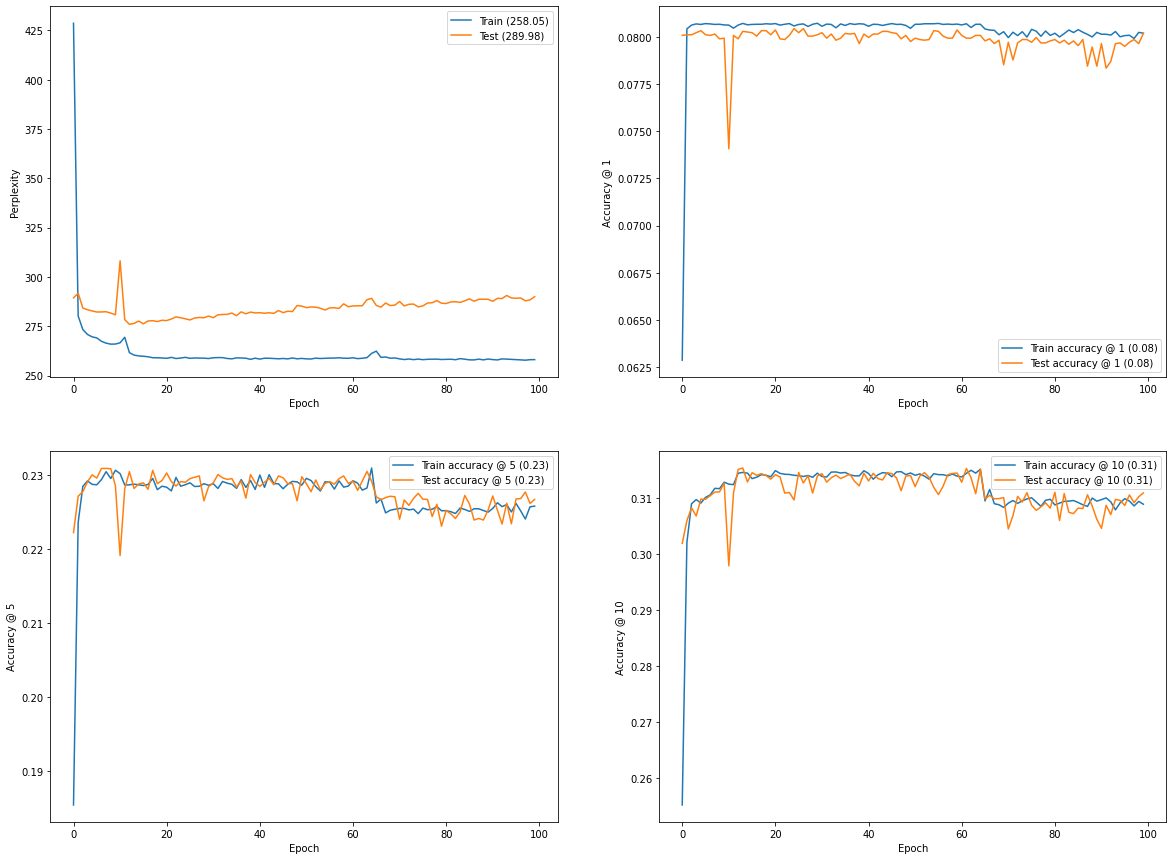

In [ ]:
# RNN trained with a learning rate of 1e-3 and embedding 32
net = RNN(vocab, embed_dim=32)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

## Number of hidden layers
The lowest test loss is obtained with 128 hidden layers.

*   Train loss: 3
*   Test loss: 15

7.54 seconds per epoch on cuda


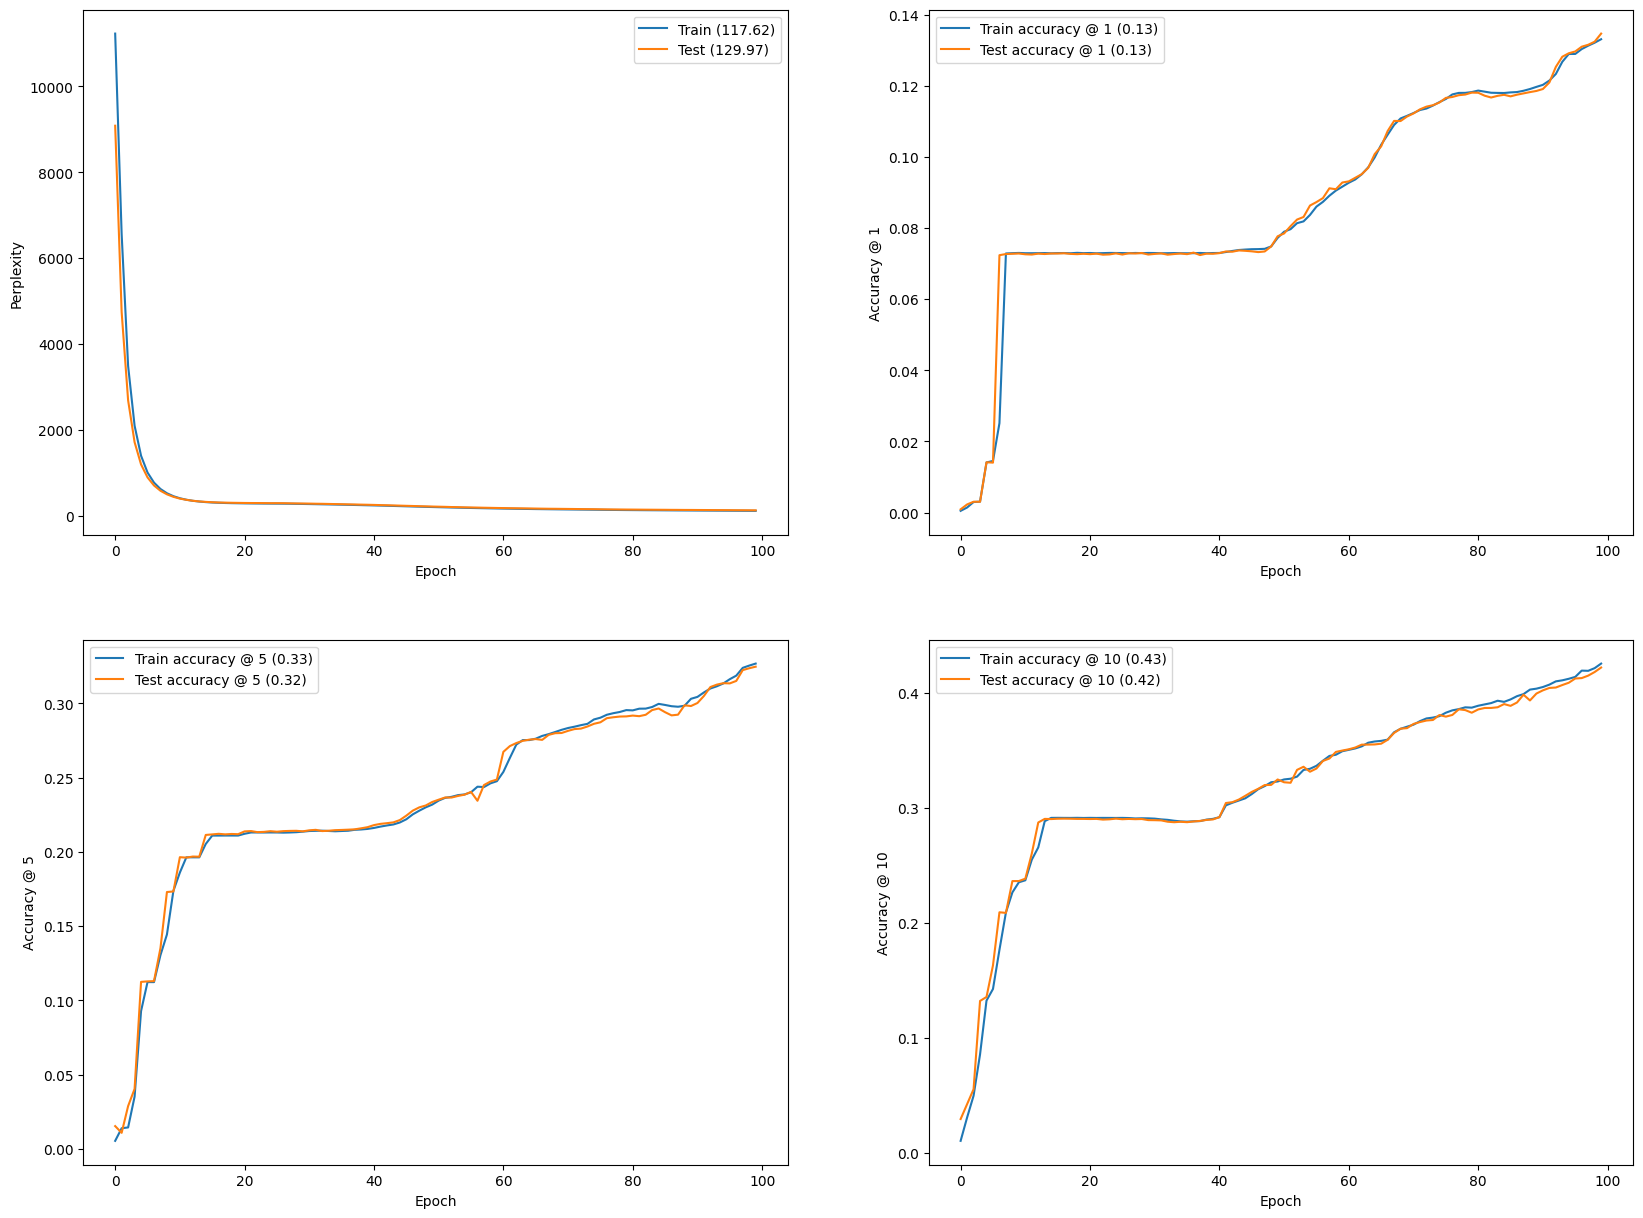

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 2 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=2)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.53 seconds per epoch on cuda


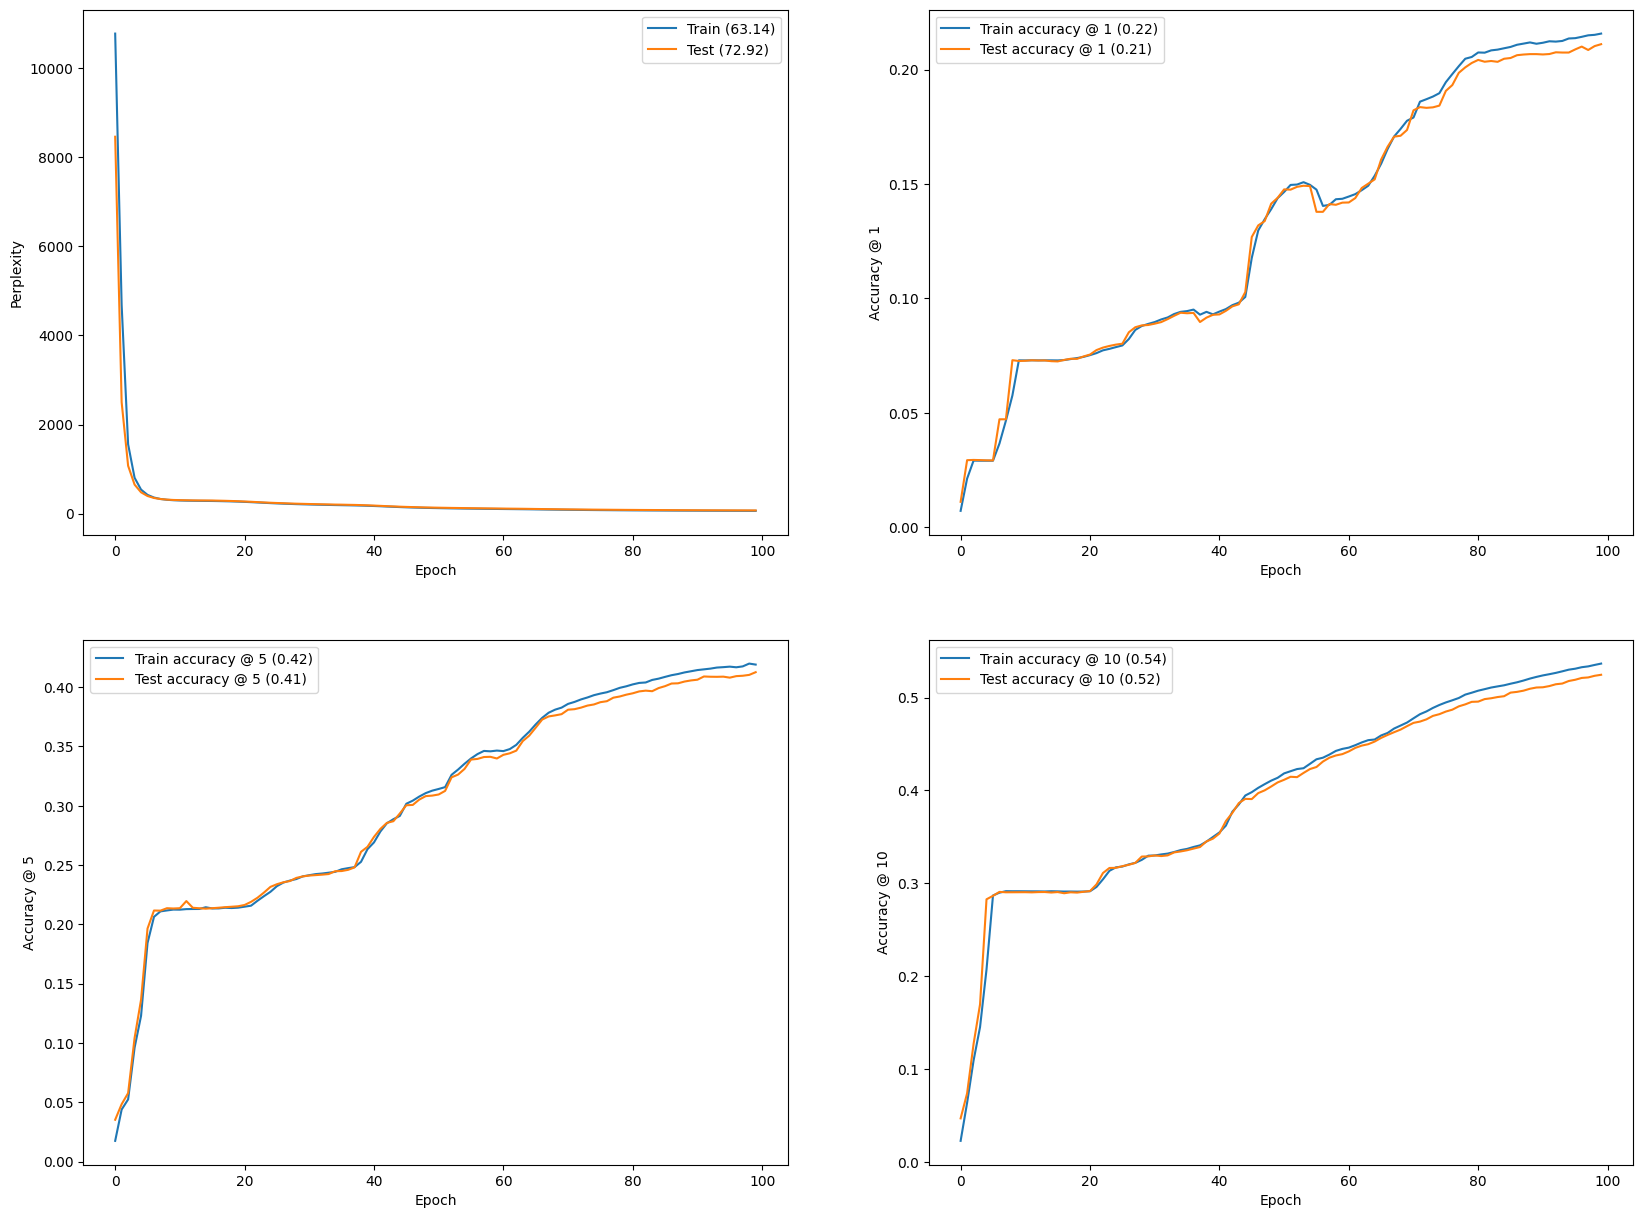

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 4 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=4)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.45 seconds per epoch on cuda


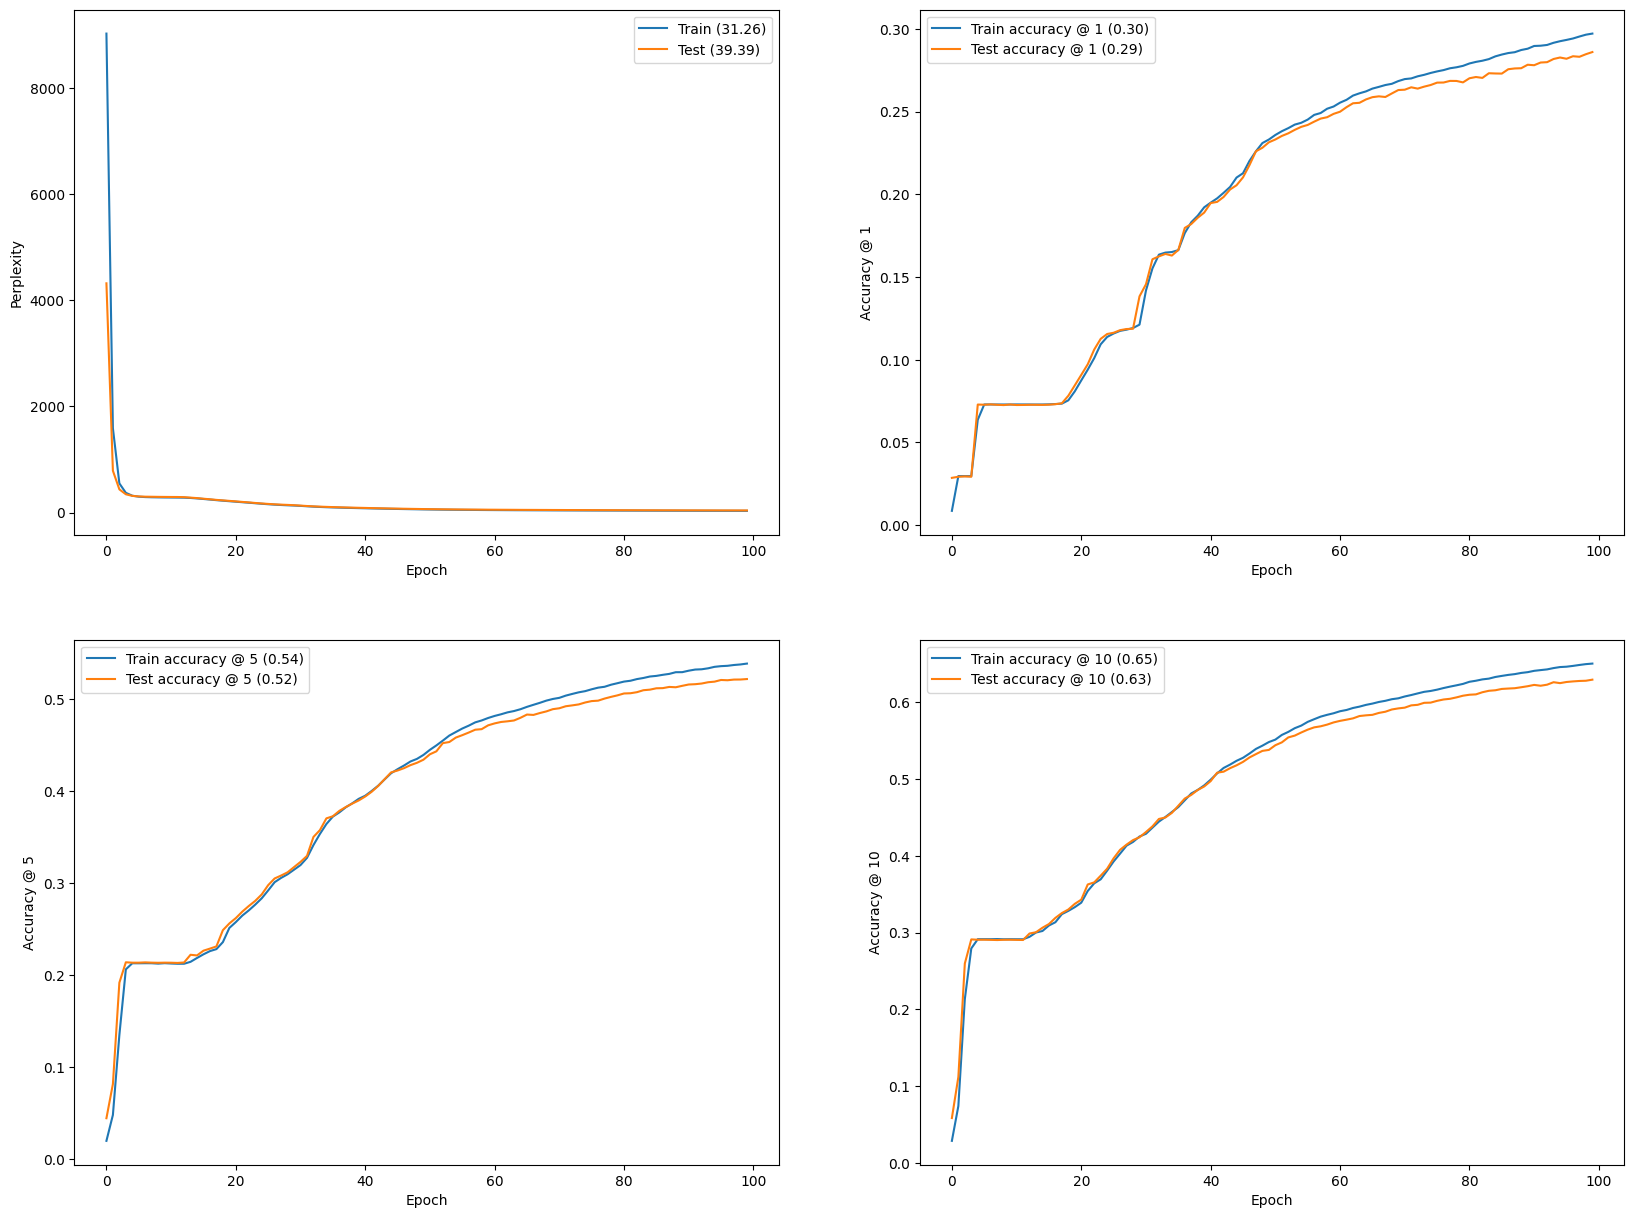

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 8 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=8)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.43 seconds per epoch on cuda


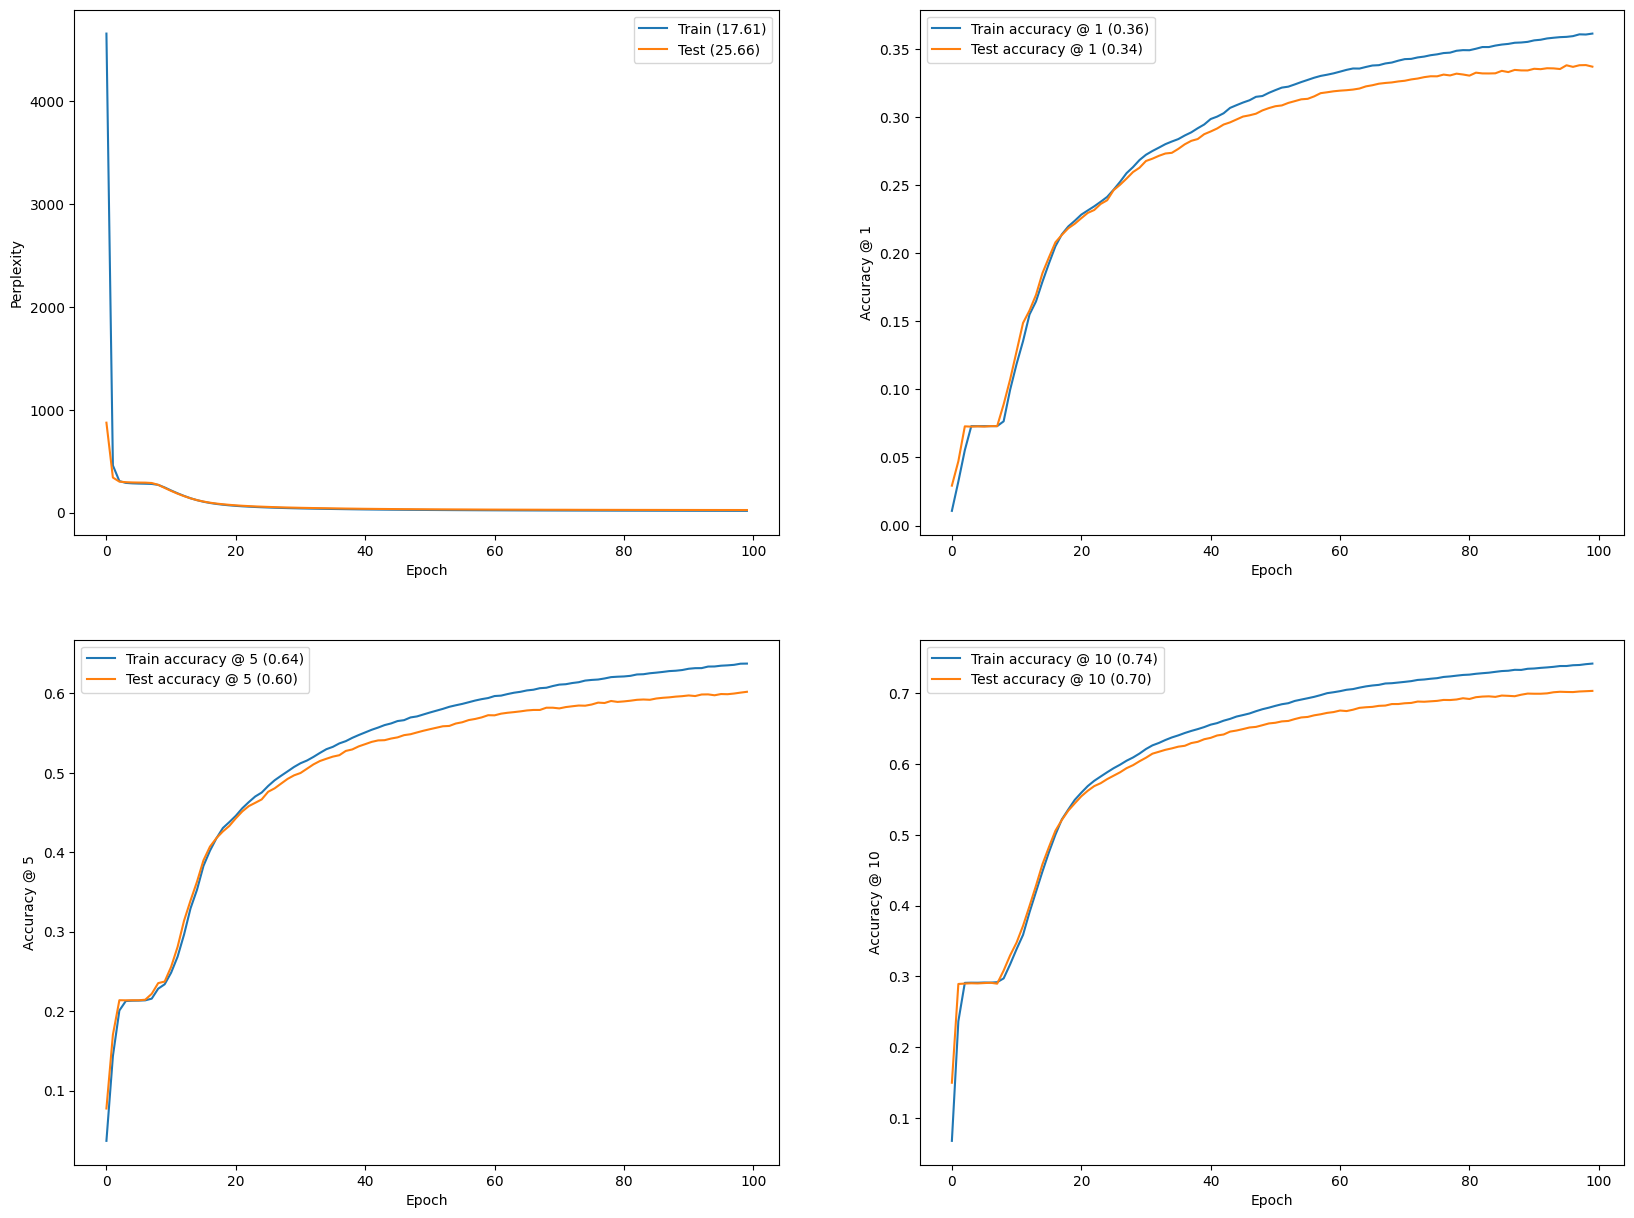

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 16 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=16)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.51 seconds per epoch on cuda


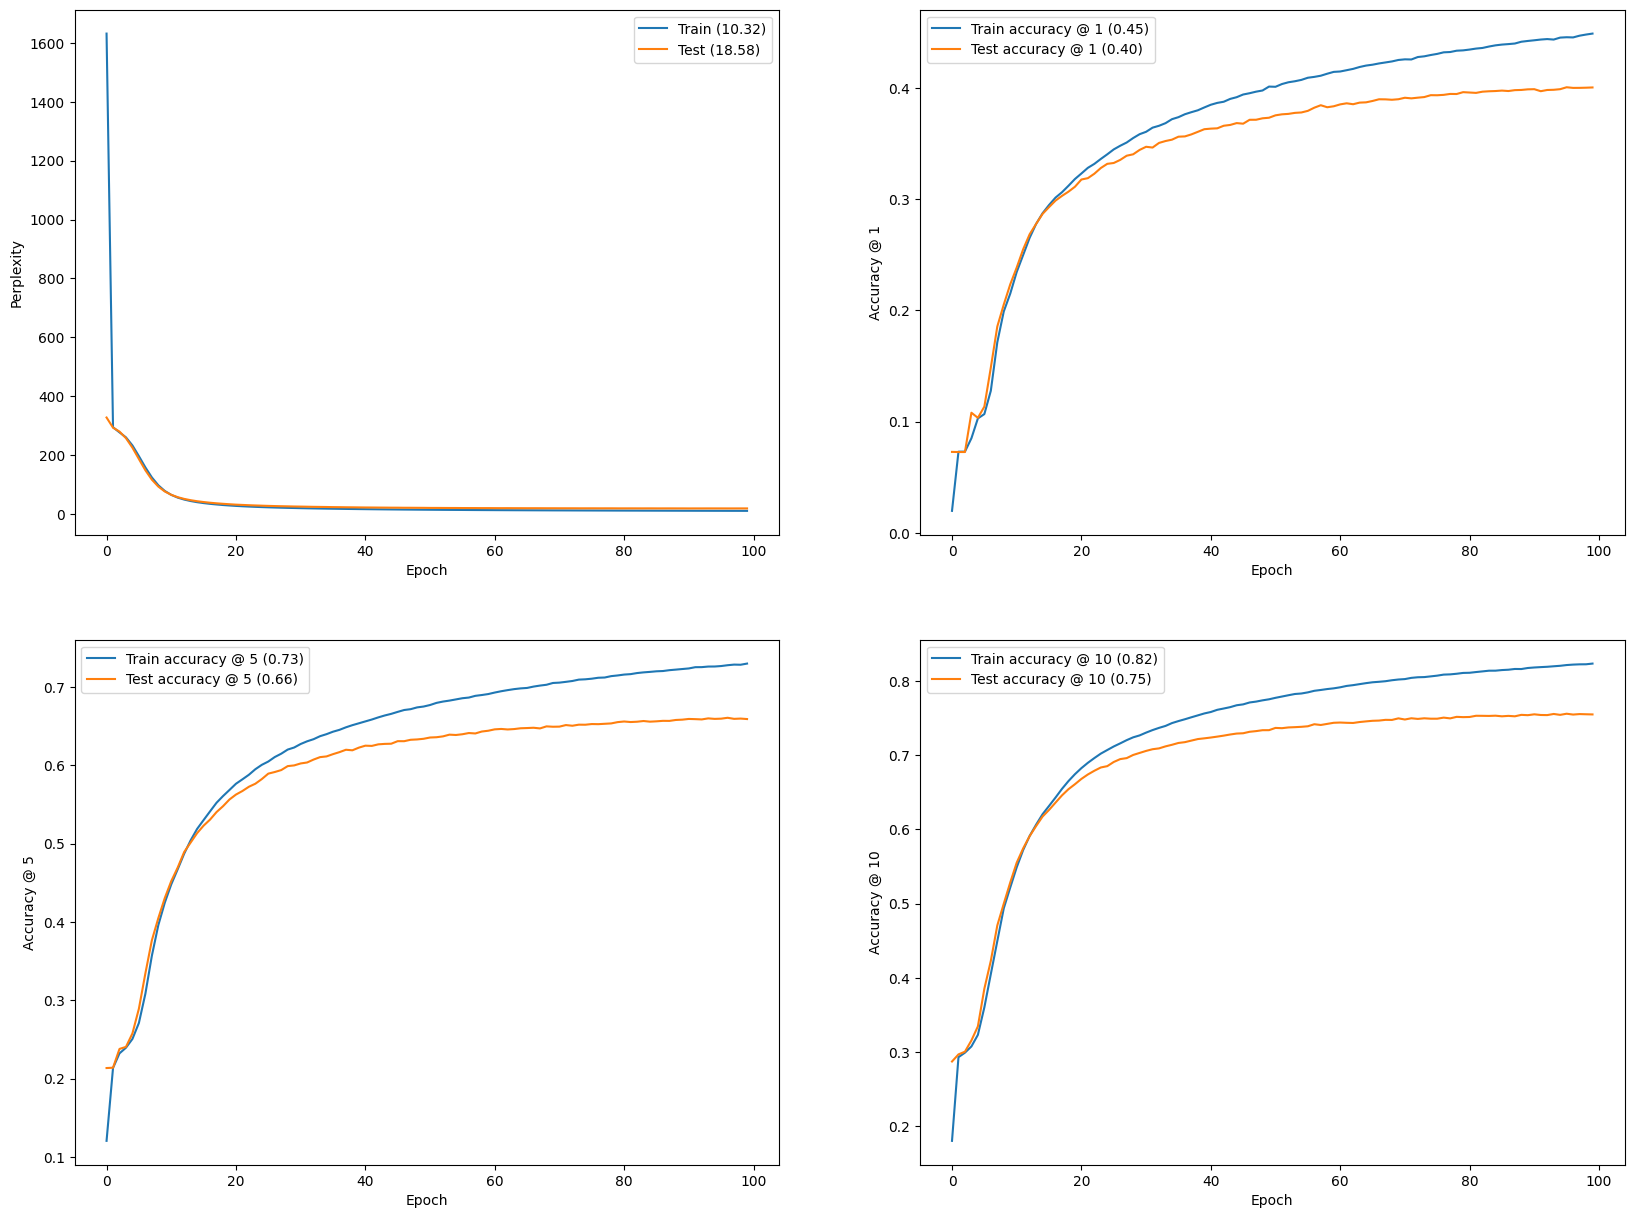

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 32 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=32)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

7.60 seconds per epoch on cuda


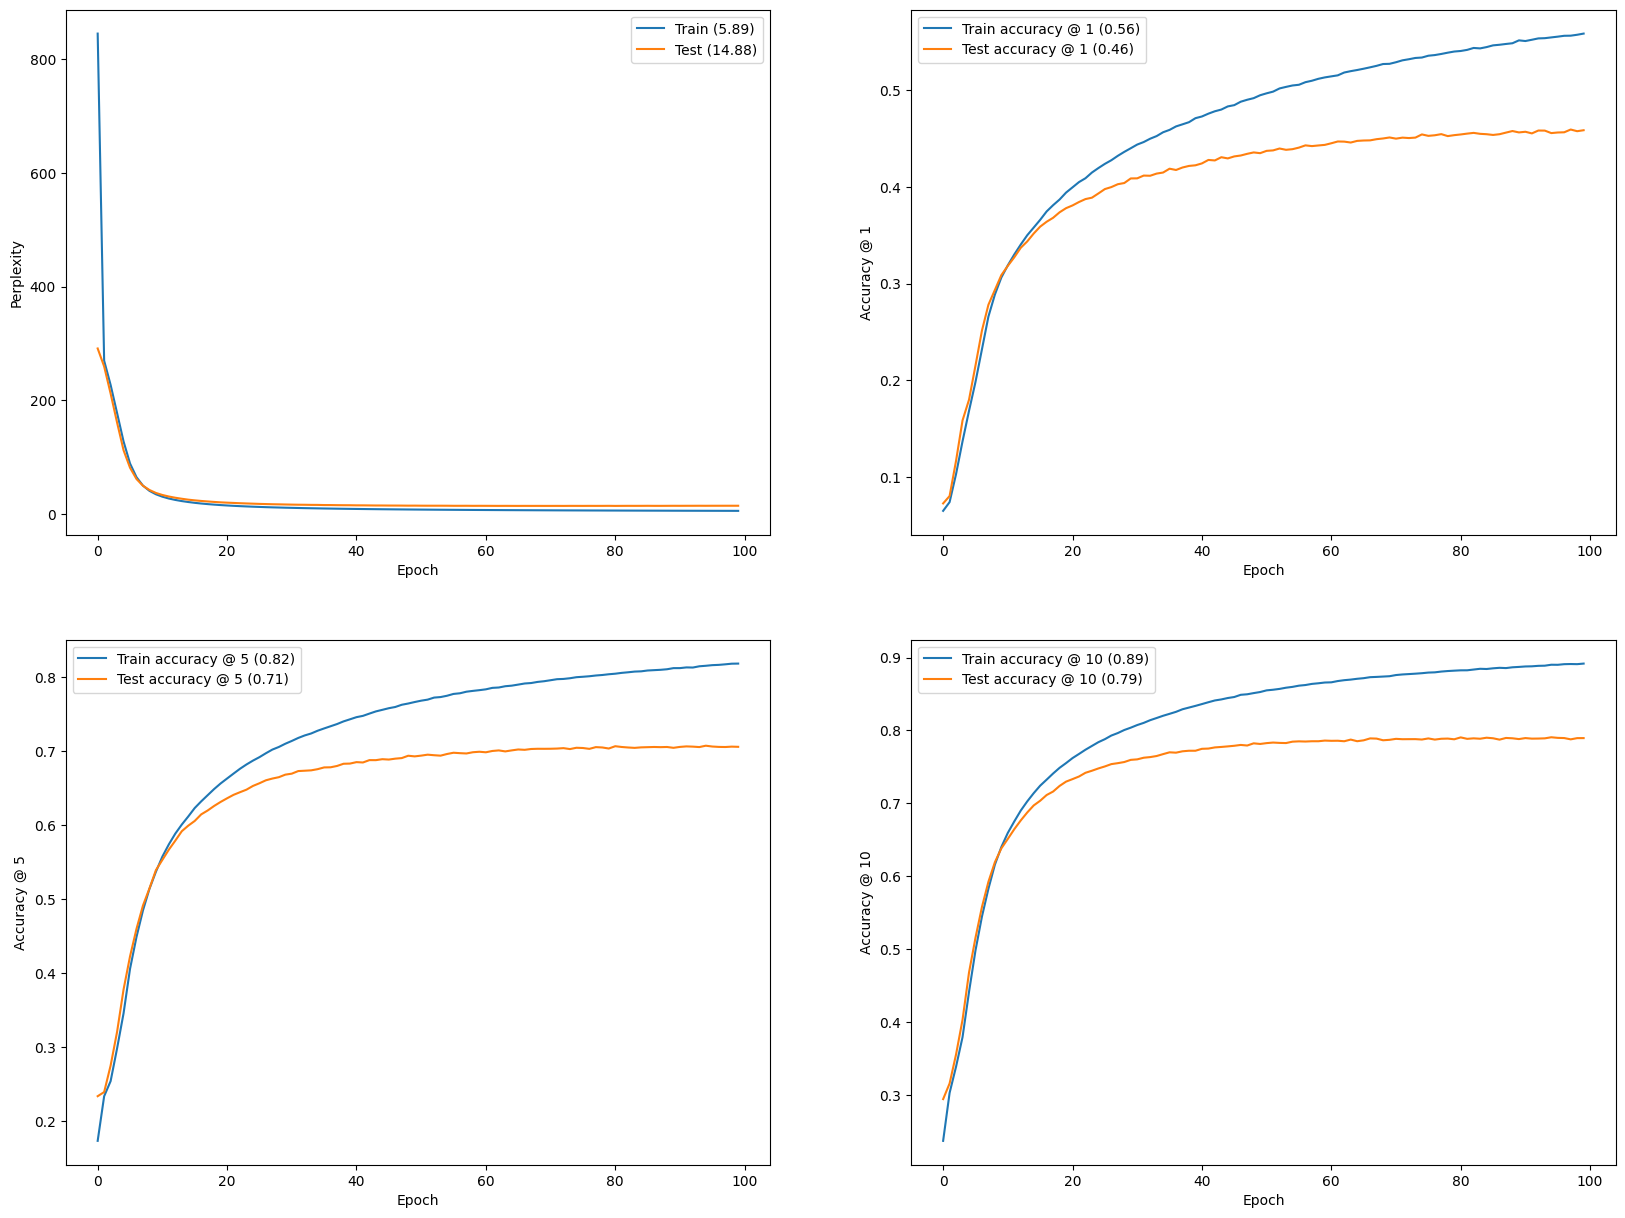

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 64 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=64)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

8.09 seconds per epoch on cuda


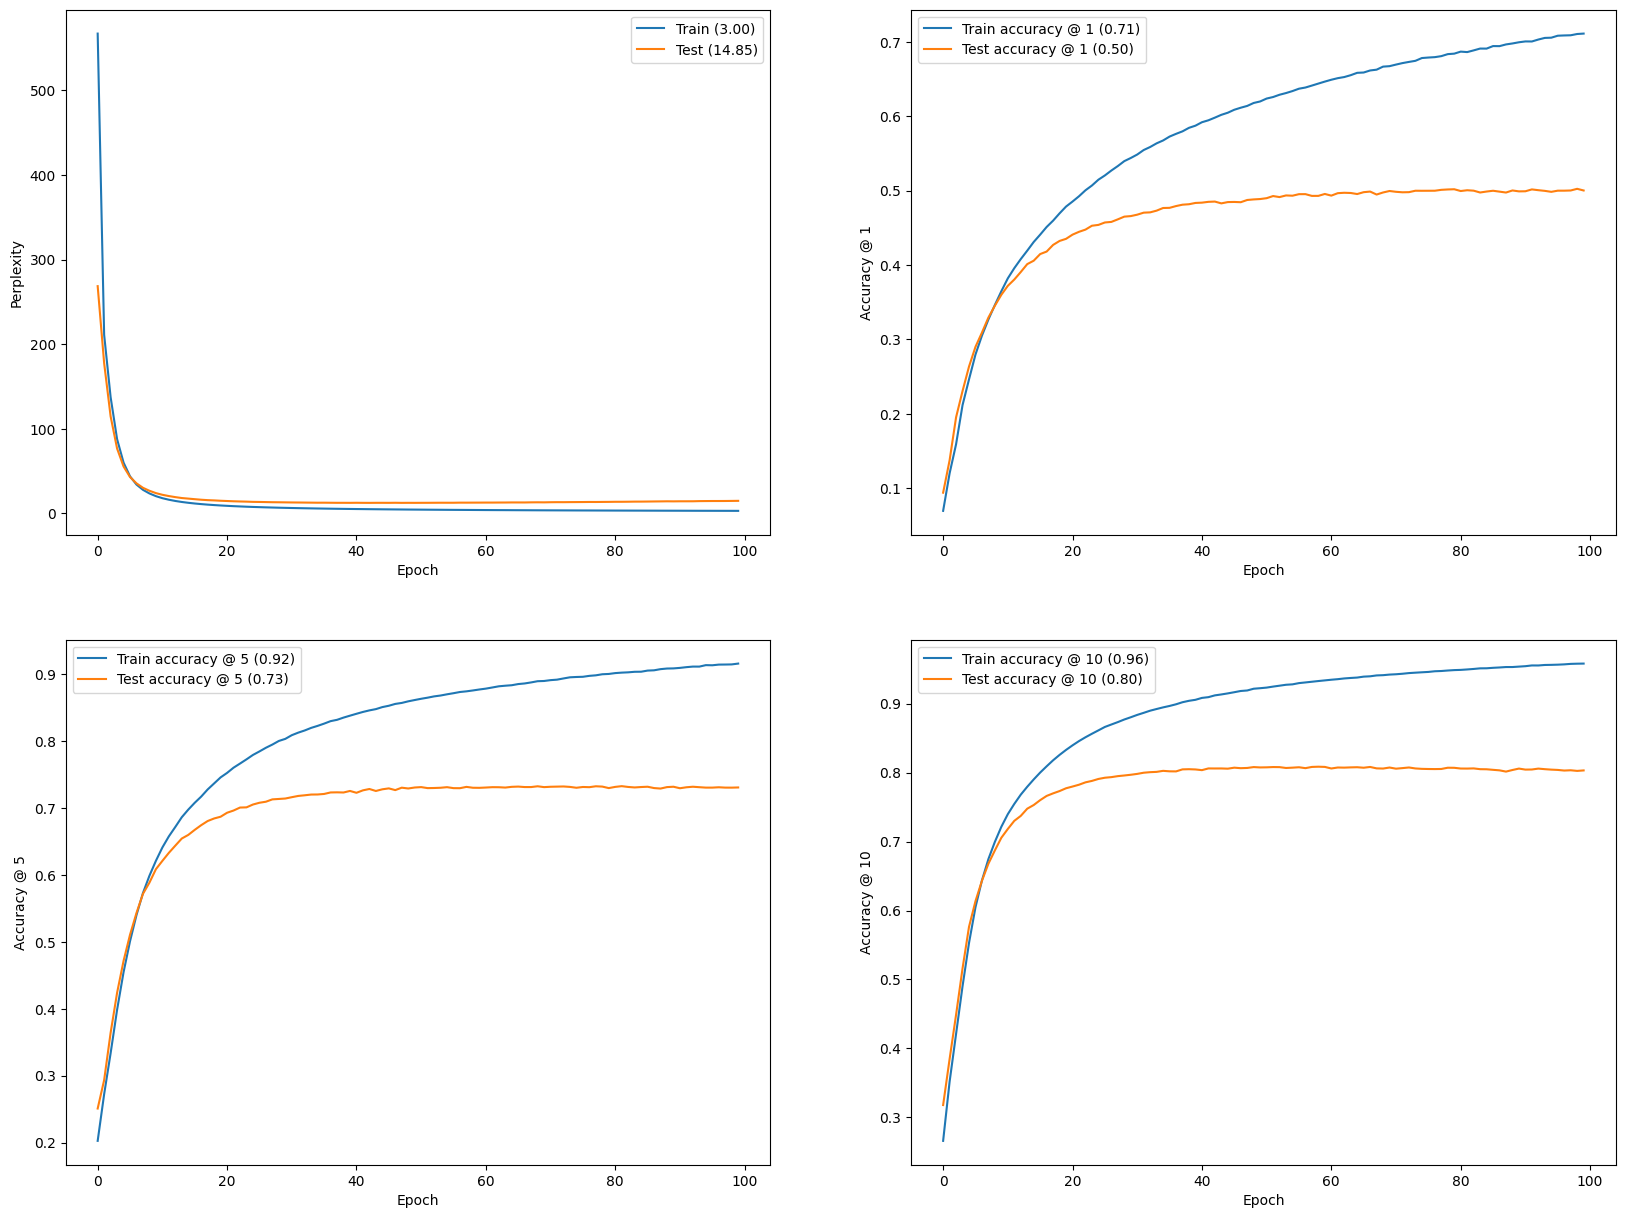

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 128 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

8.85 seconds per epoch on cuda


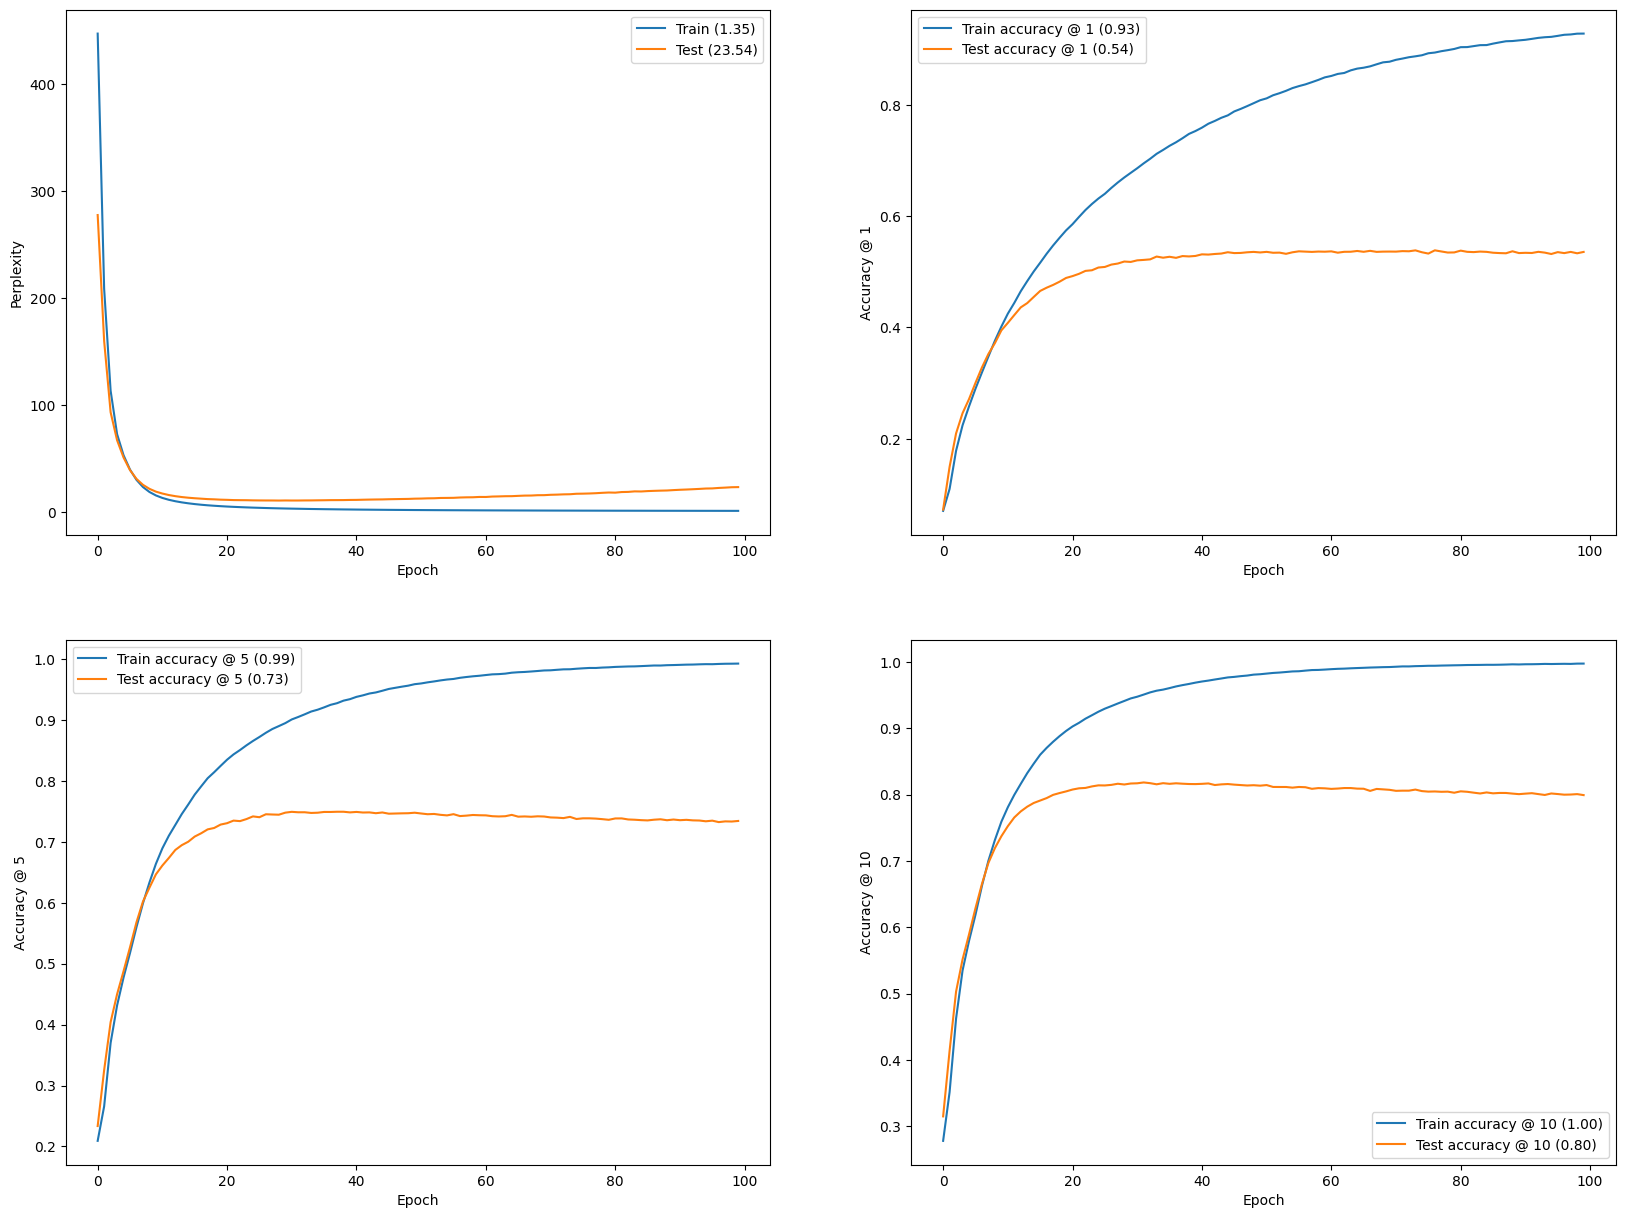

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 256 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=256)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

11.80 seconds per epoch on cuda


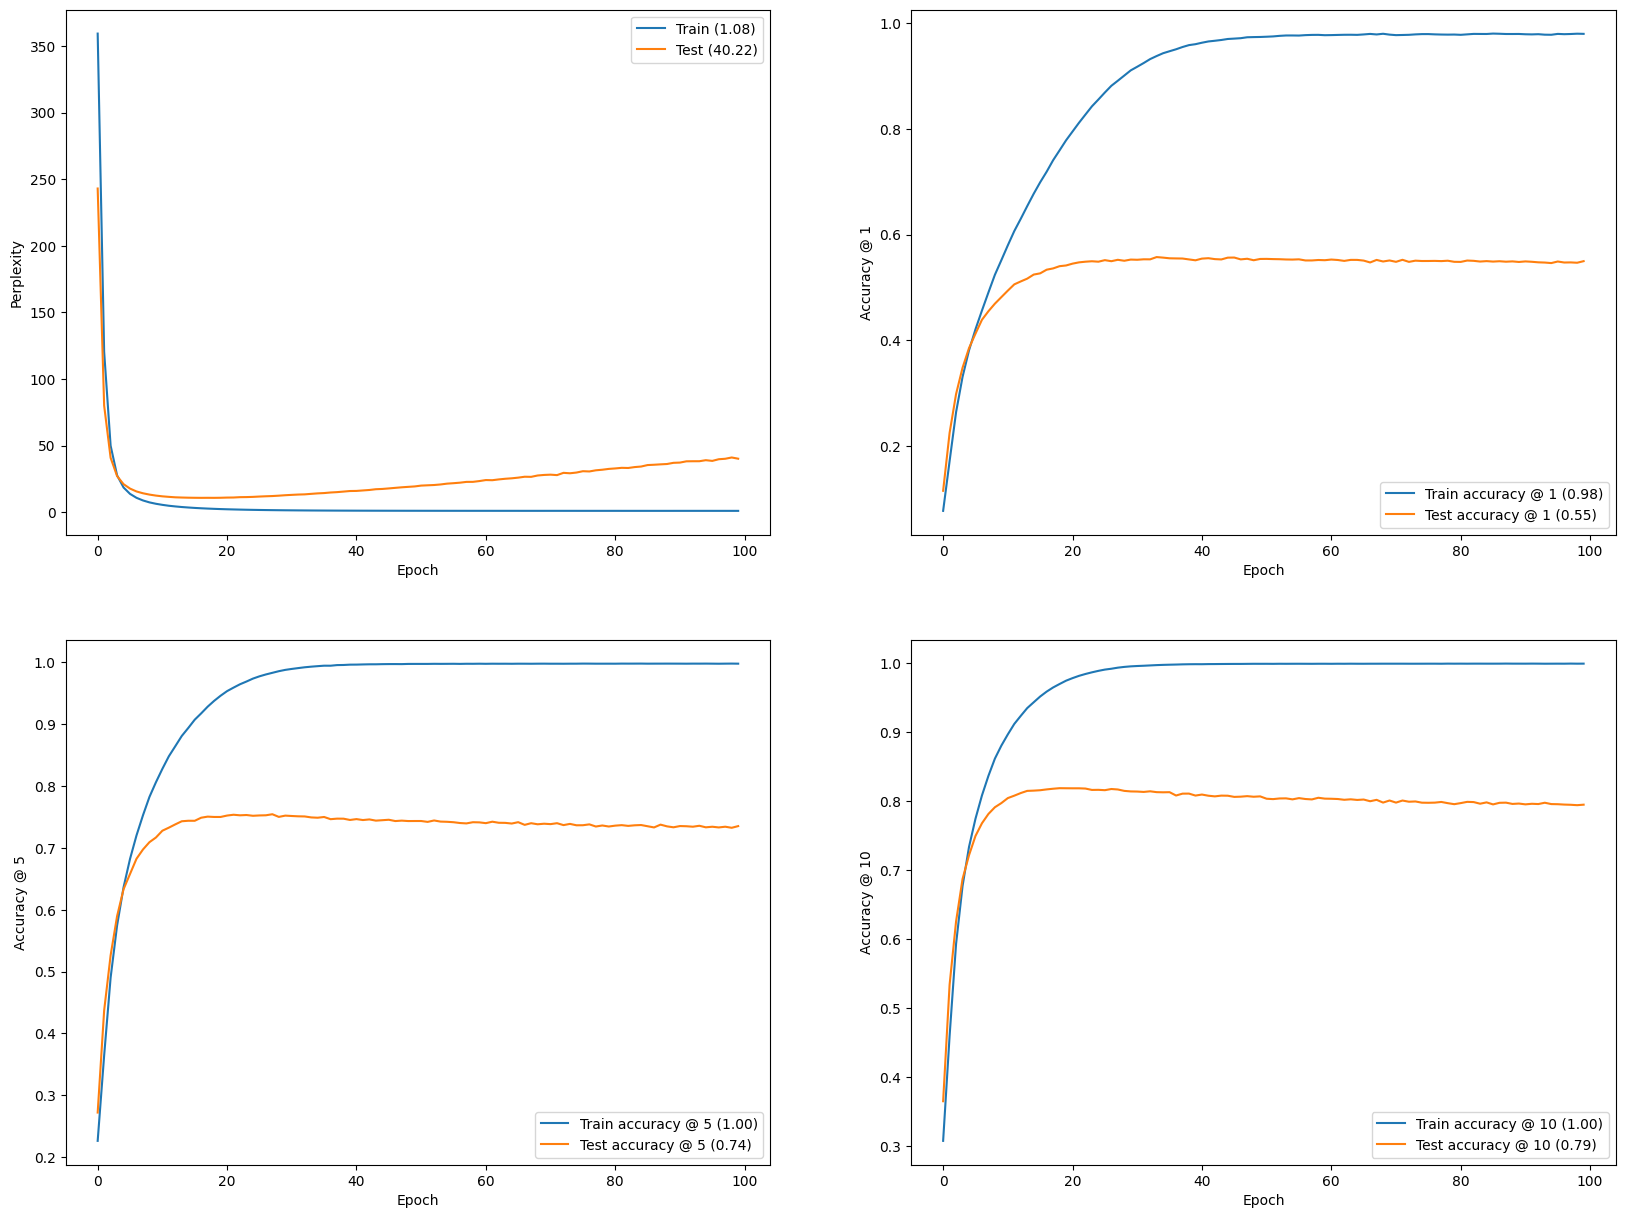

In [ ]:
# RNN with learning rate of 1e-3, 8 embedding dimensions and 512 hidden layers
net = RNN(vocab, embed_dim=8, num_hiddens=512)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

## Number of GRUs
No increase in GRUs provide better results than having only one GRU layer.

9.64 seconds per epoch on cuda


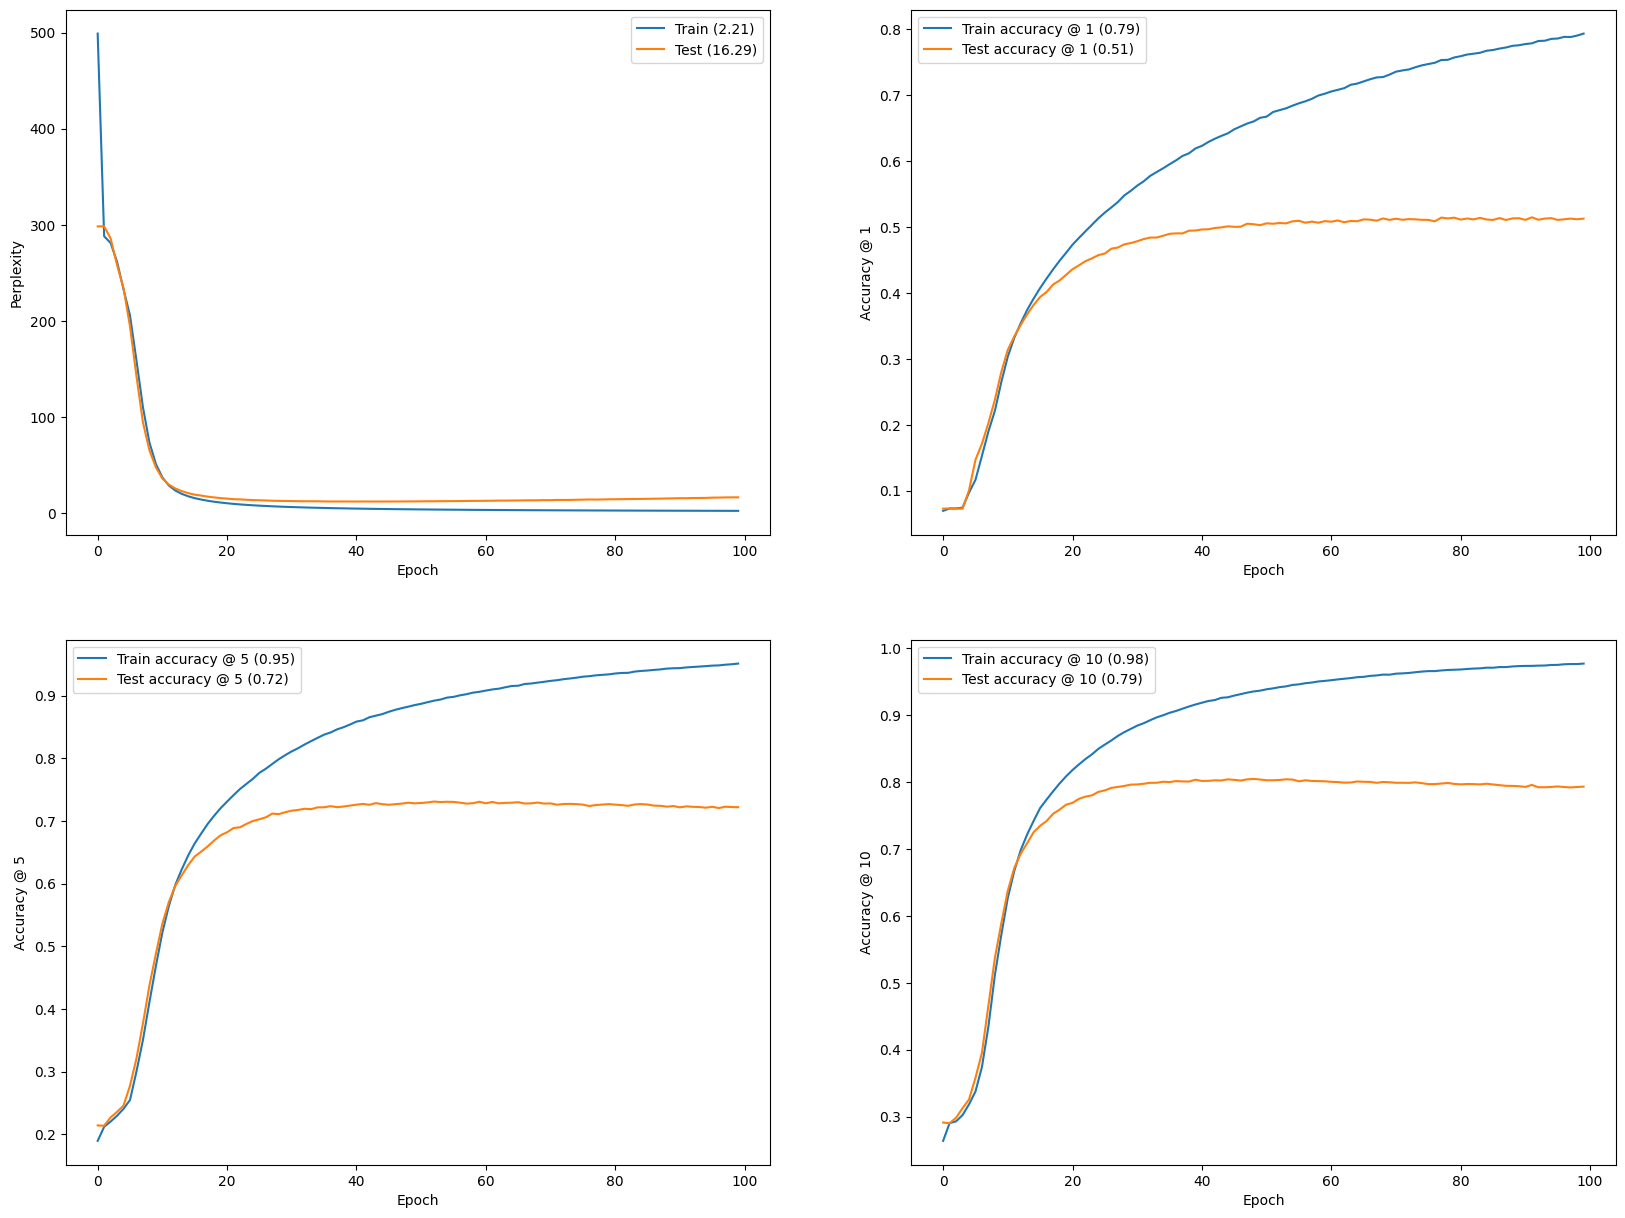

In [ ]:
# RNN with learning rate of 1e-3 and 2 GRUs
net = RNN(vocab, embed_dim=8, num_hiddens=128, num_layers=2)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

11.19 seconds per epoch on cuda


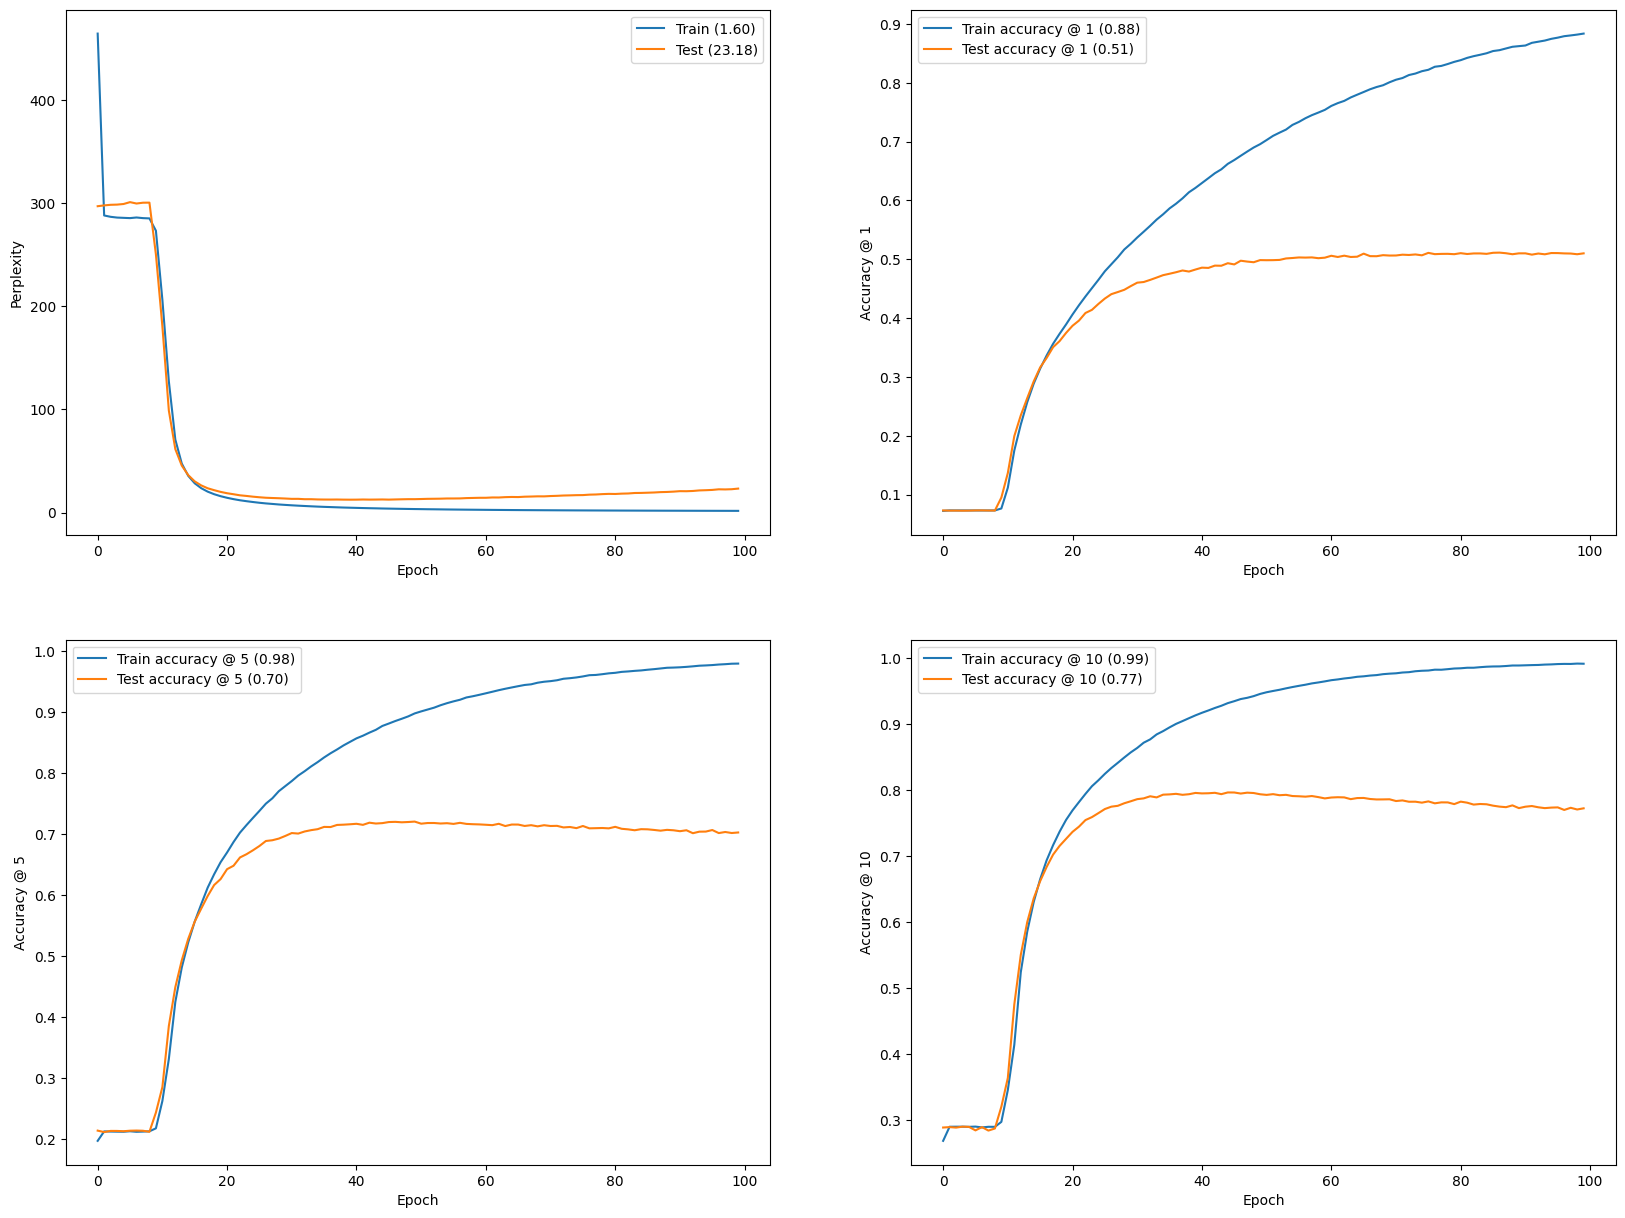

In [ ]:
# RNN with learning rate of 1e-3 and 4 GRUs
net = RNN(vocab, embed_dim=8, num_hiddens=128, num_layers=4)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

## Directionality
Considering both directions improves the model slightly. However, the model overfits.

9.38 seconds per epoch on cuda


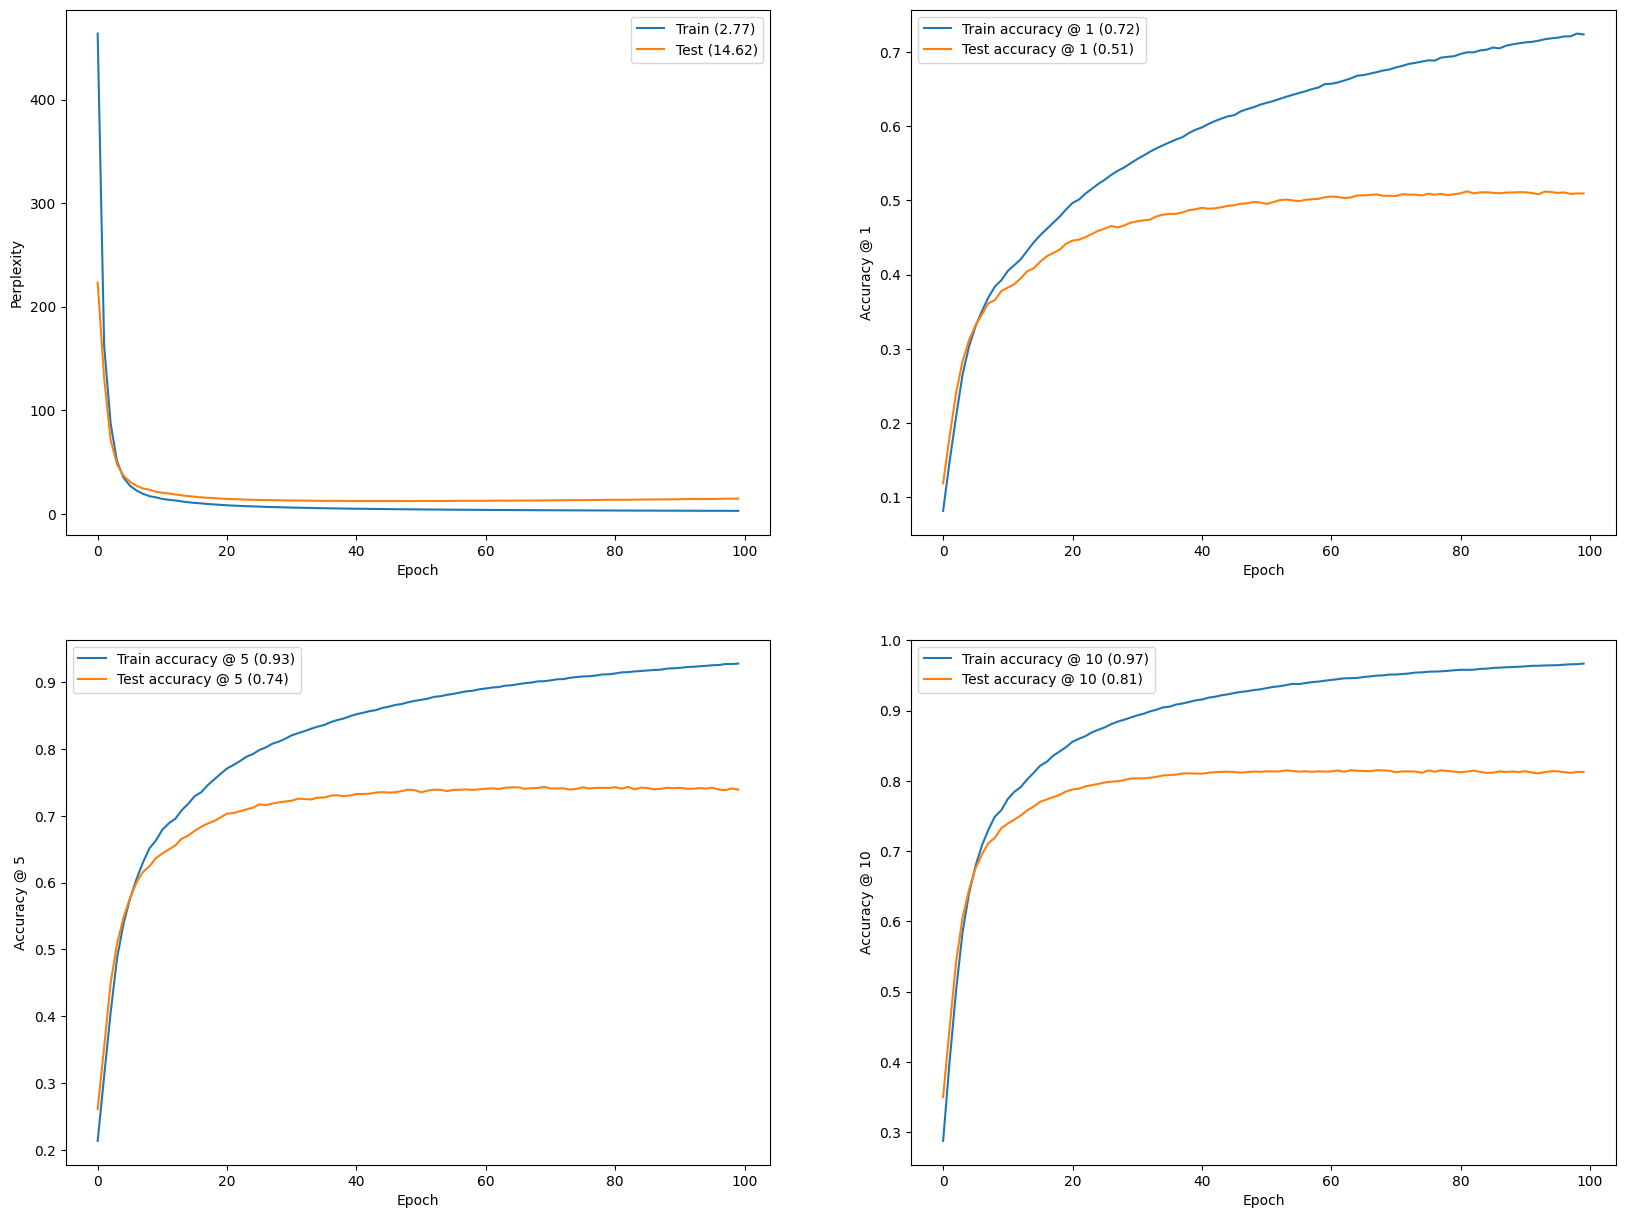

In [ ]:
# RNN with learning rate of 1e-3, 128 hidden layers, 1 bidirectional GRU
net = RNN(vocab, embed_dim=8, num_hiddens=128, bidirectional=True)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

10.93 seconds per epoch on cuda


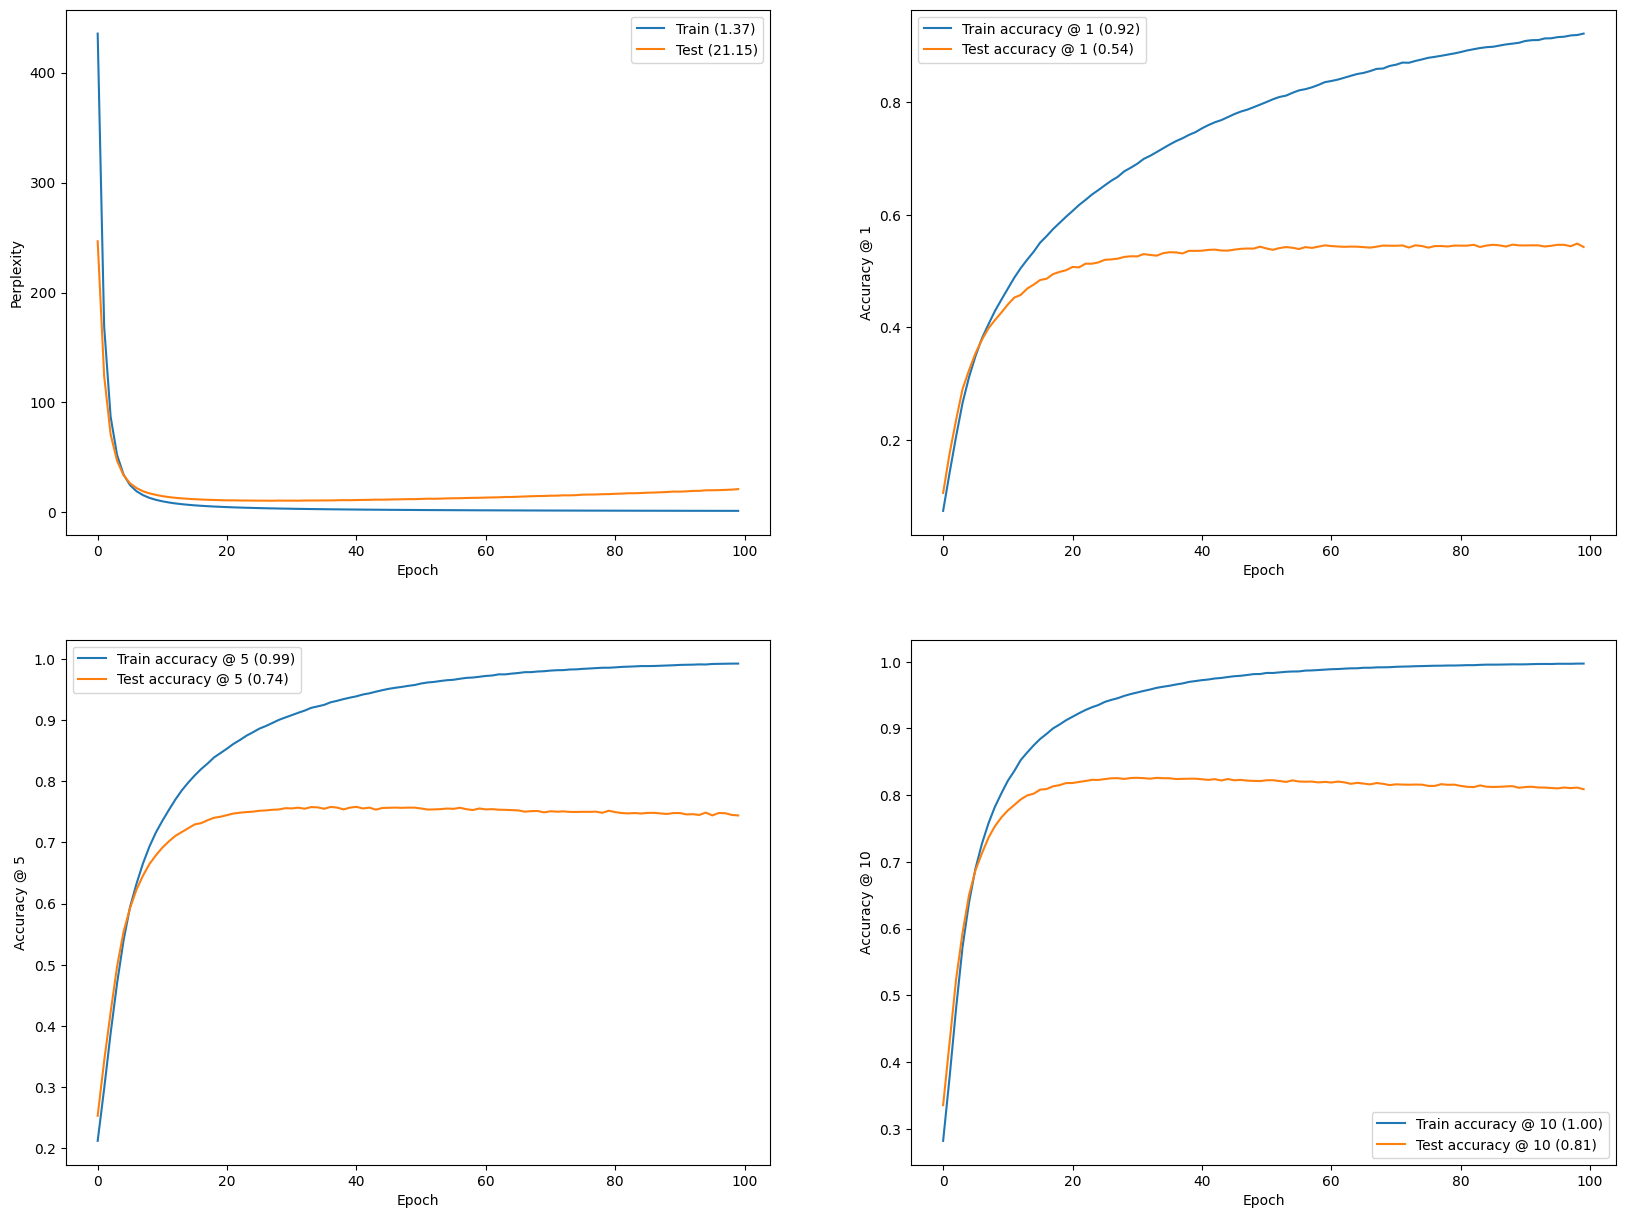

In [ ]:
# RNN with learning rate of 1e-3, 128 hidden layers, 2 bidirectional GRUs
net = RNN(vocab, embed_dim=8, num_hiddens=128, num_layers=2, bidirectional=True)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

Bidirectionality significantly improves results!

## The best parameters

*   Learning rate of 1e-3
*   8 embedding dimensions
*   128 hidden layers
*   1 one directional GRU layer



```
lr = 1e-3
# create model
net = RNN(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
```

# Recipe length
Different recipe lengths are assessed with the best model

7.42 seconds per epoch on cuda


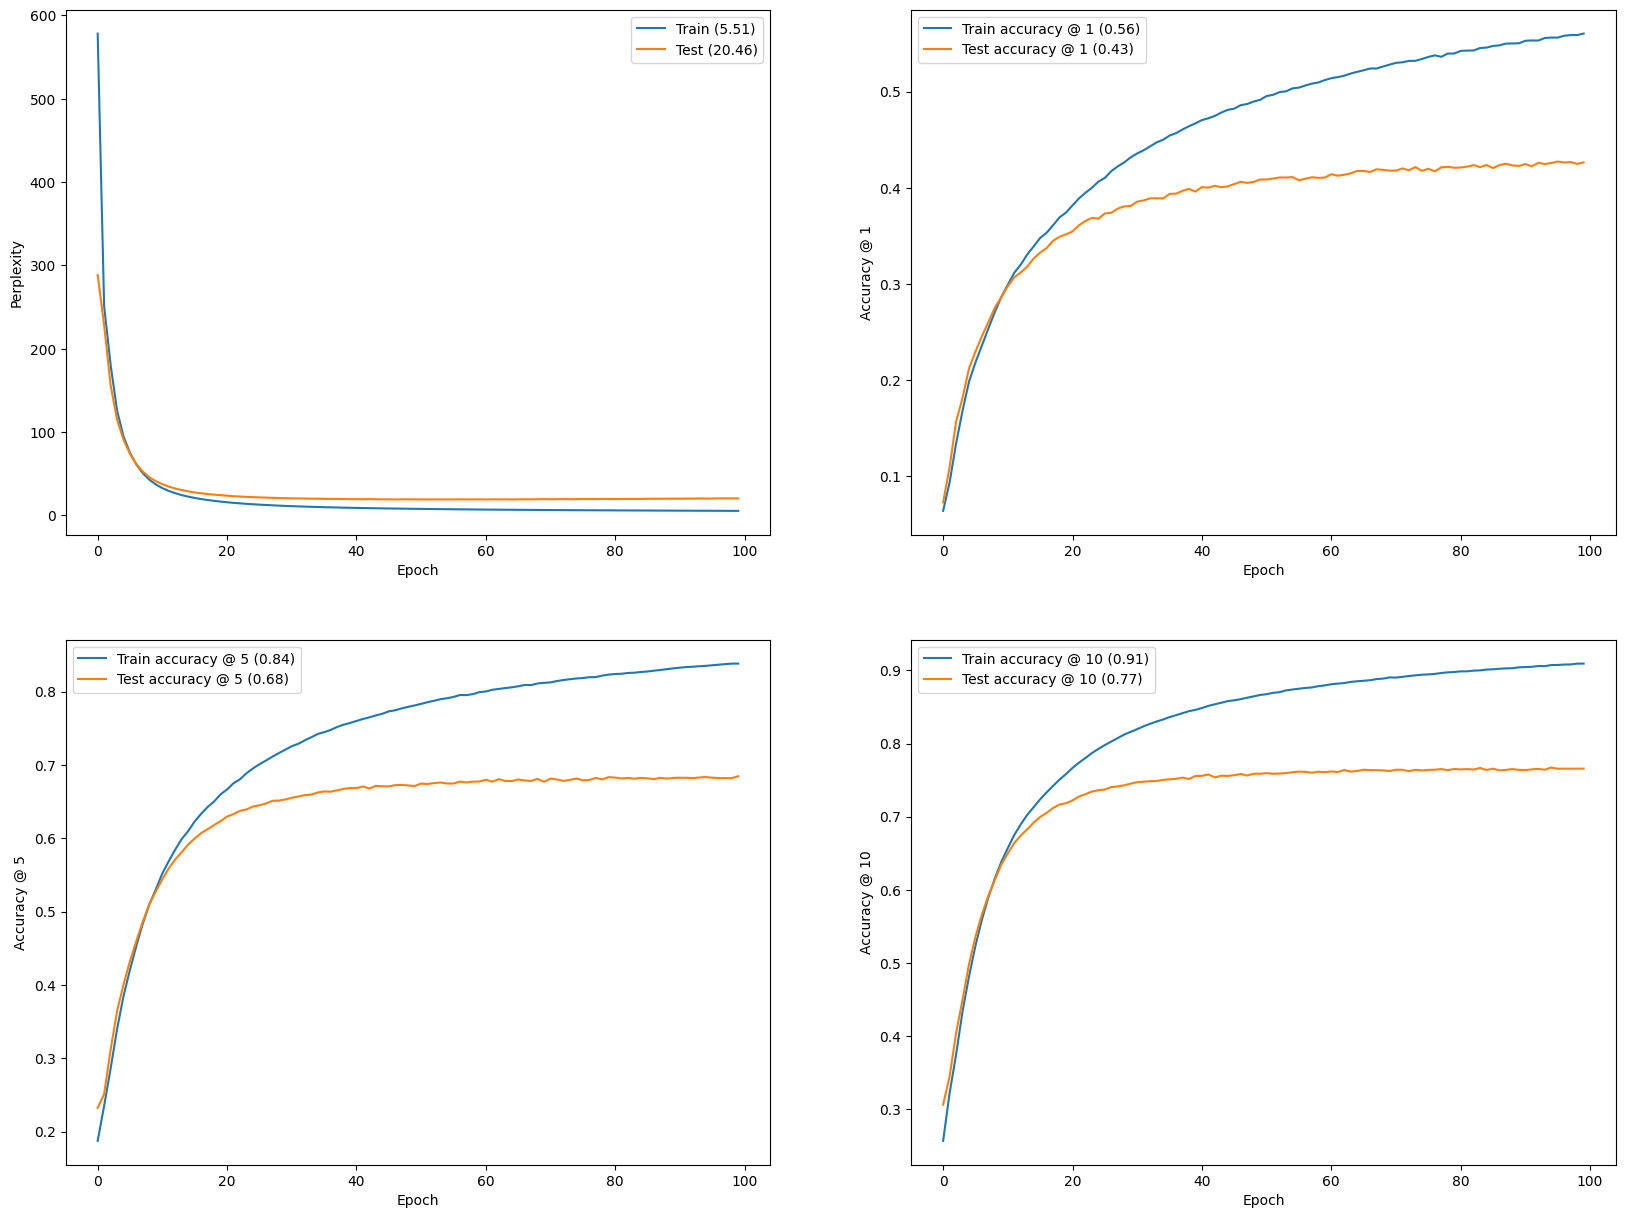

In [ ]:
# set max recipe length
length = 5
# read training data
train_data = RNNData(train_df, vocab, length)
train_iter = DataLoader(train_data, batch_size, shuffle=True, drop_last=True)

# read test data
test_data = RNNData(test_df, vocab, length)
test_iter = DataLoader(test_data, batch_size, shuffle=True, drop_last=True)

lr = 1e-3
# create model
net = RNN(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
# plot results
plot(train, test)

7.68 seconds per epoch on cuda


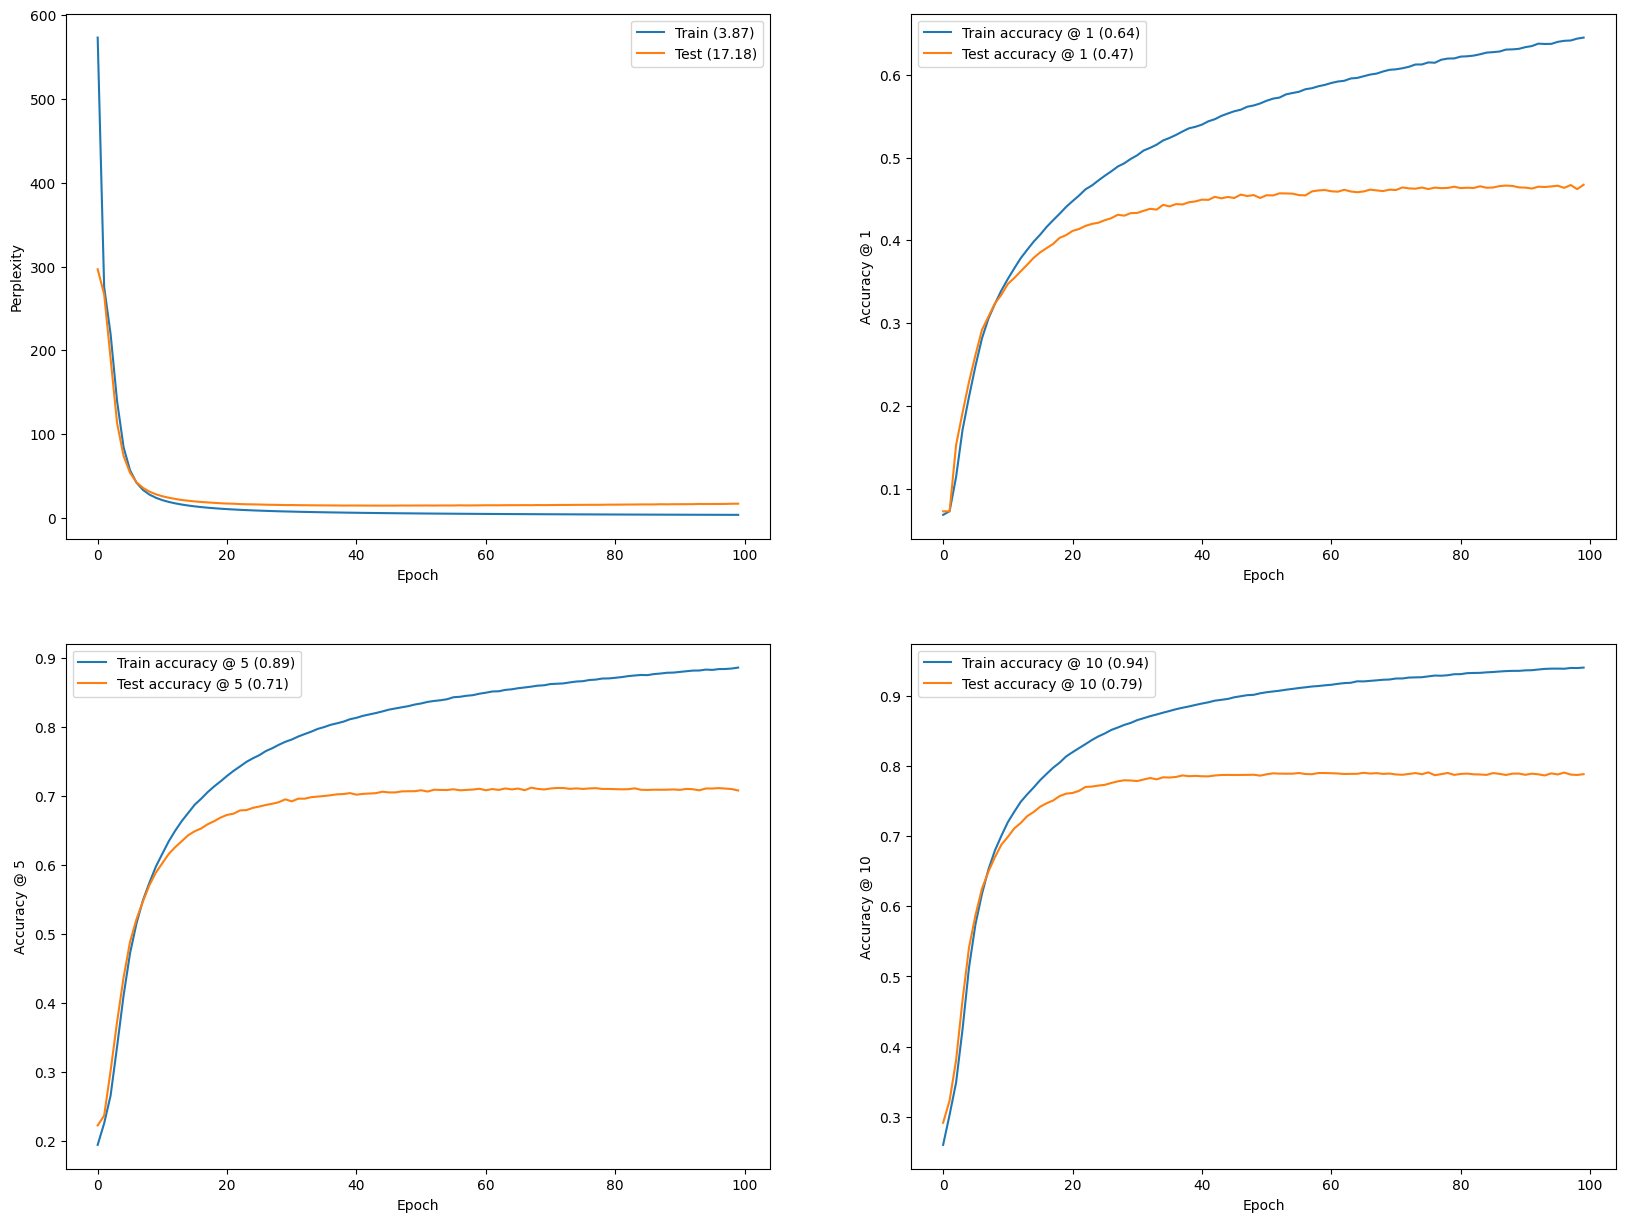

In [ ]:
# set max recipe length
length = 10
# read training data
train_data = RNNData(train_df, vocab, length)
train_iter = DataLoader(train_data, batch_size, shuffle=True, drop_last=True)

# read test data
test_data = RNNData(test_df, vocab, length)
test_iter = DataLoader(test_data, batch_size, shuffle=True, drop_last=True)

lr = 1e-3
# create model
net = RNN(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
# plot results
plot(train, test)

8.60 seconds per epoch on cuda


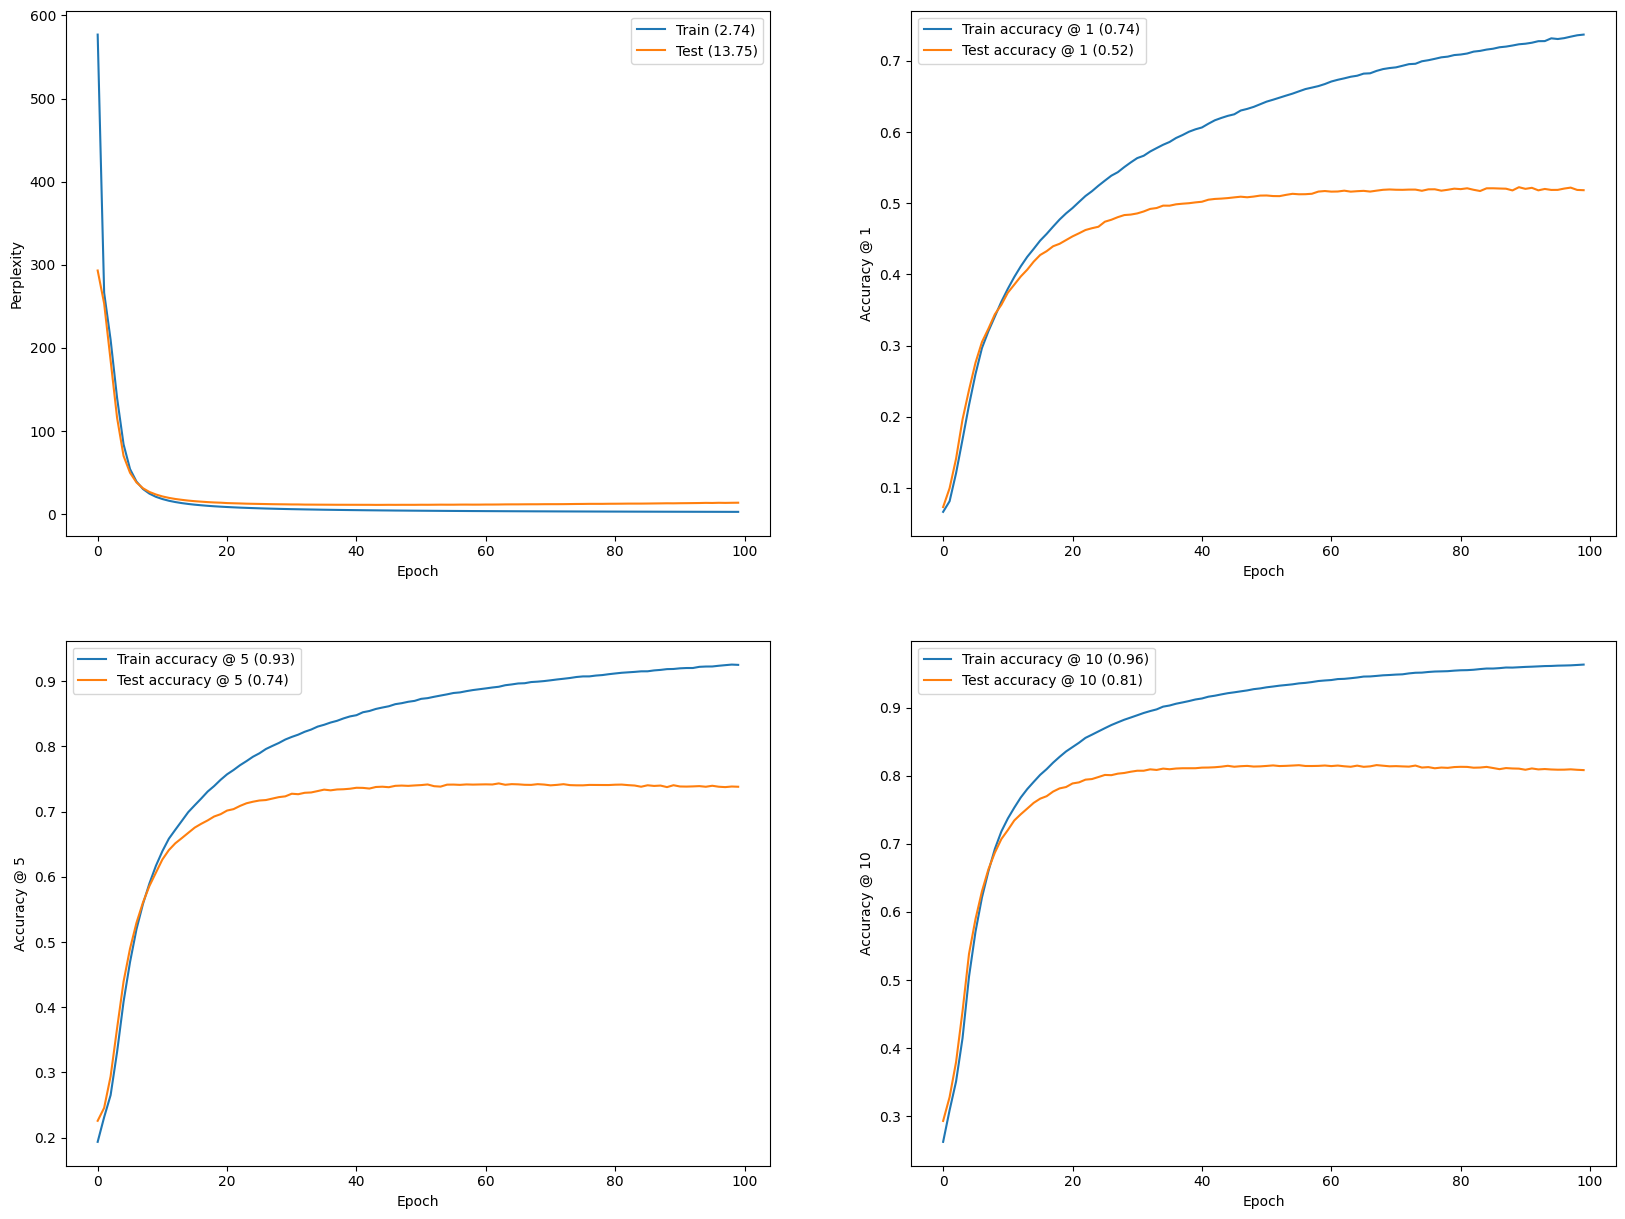

In [ ]:
# set max recipe length
length = 30
# read training data
train_data = RNNData(train_df, vocab, length)
train_iter = DataLoader(train_data, batch_size, shuffle=True, drop_last=True)

# read test data
test_data = RNNData(test_df, vocab, length)
test_iter = DataLoader(test_data, batch_size, shuffle=True, drop_last=True)

lr = 1e-3
# create model
net = RNN(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
# plot results
plot(train, test)

9.72 seconds per epoch on cuda


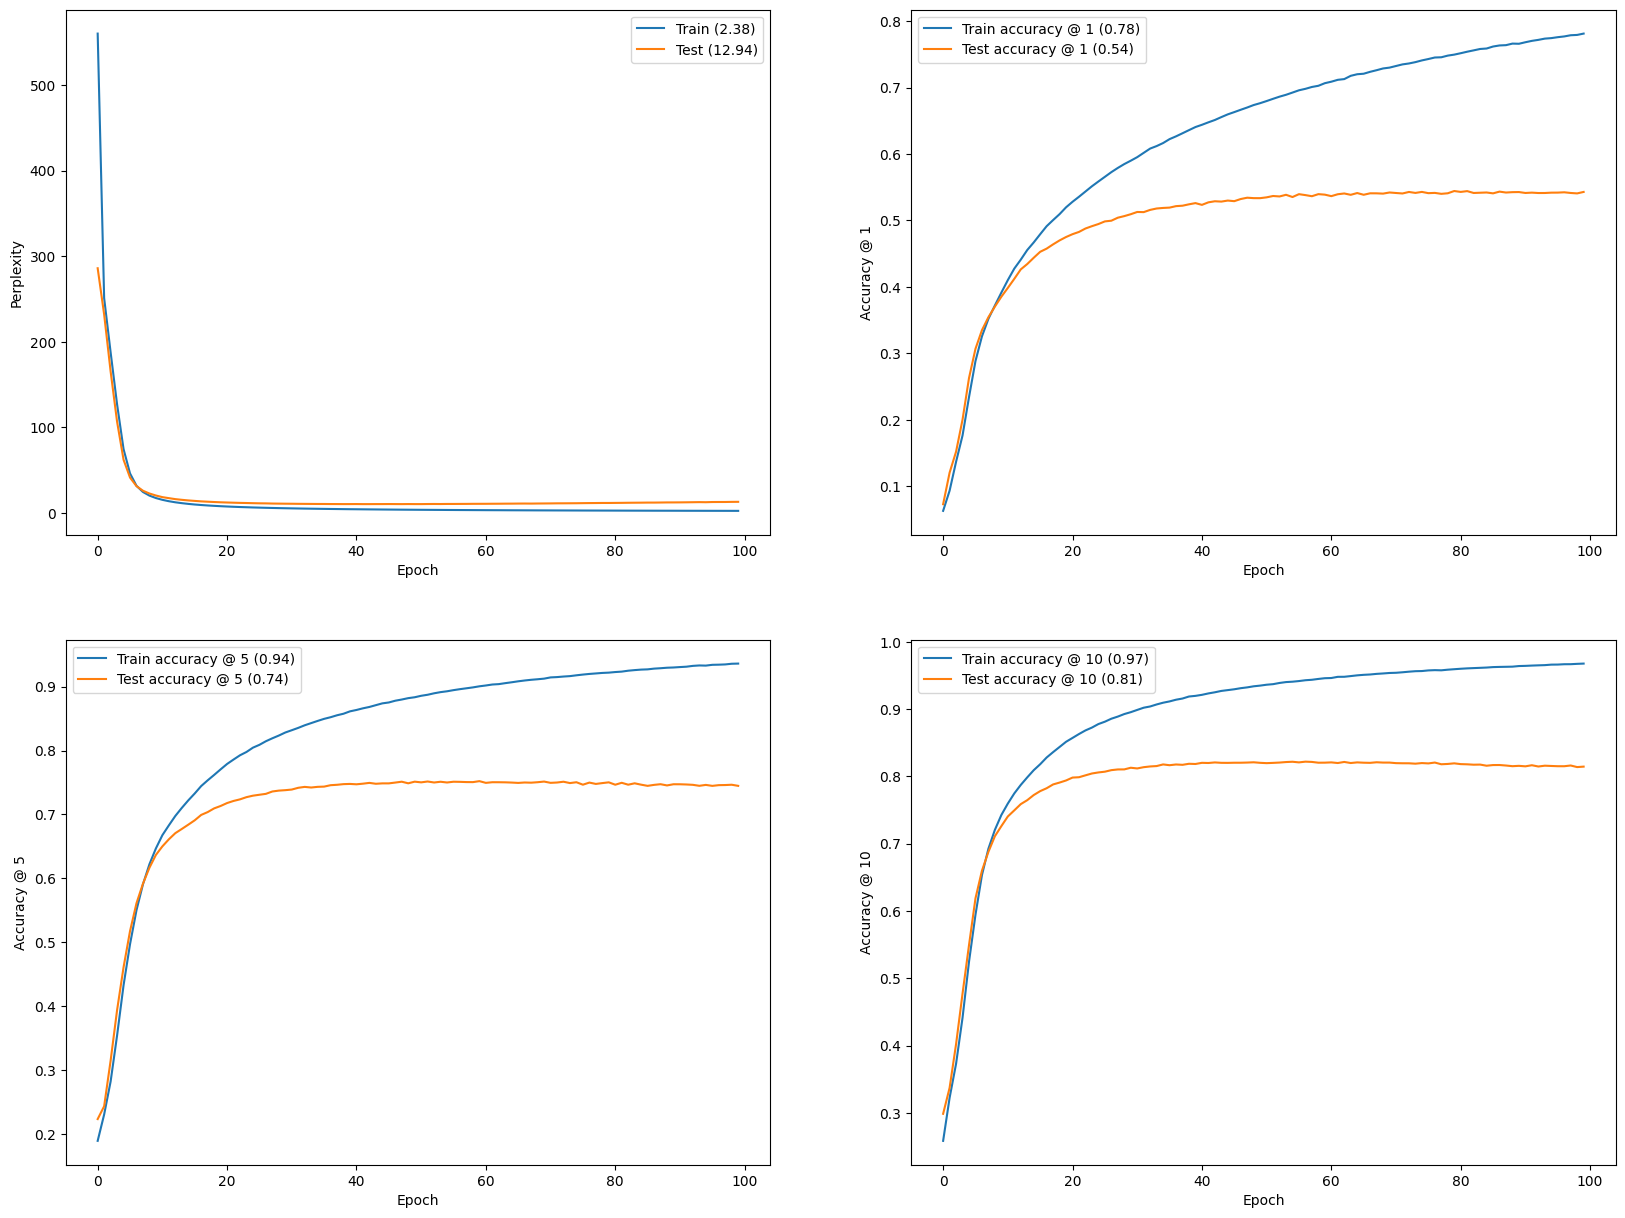

In [ ]:
# no upper limit on length
# read training data
train_data = RNNData(train_df, vocab)
train_iter = DataLoader(train_data, batch_size, shuffle=True, drop_last=True)

# read test data
test_data = RNNData(test_df, vocab)
test_iter = DataLoader(test_data, batch_size, shuffle=True, drop_last=True)

lr = 1e-3
# create model
net = RNN(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
# plot results
plot(train, test)

# Postpadding
Assess how postpadding affects results.

8.48 seconds per epoch on cuda


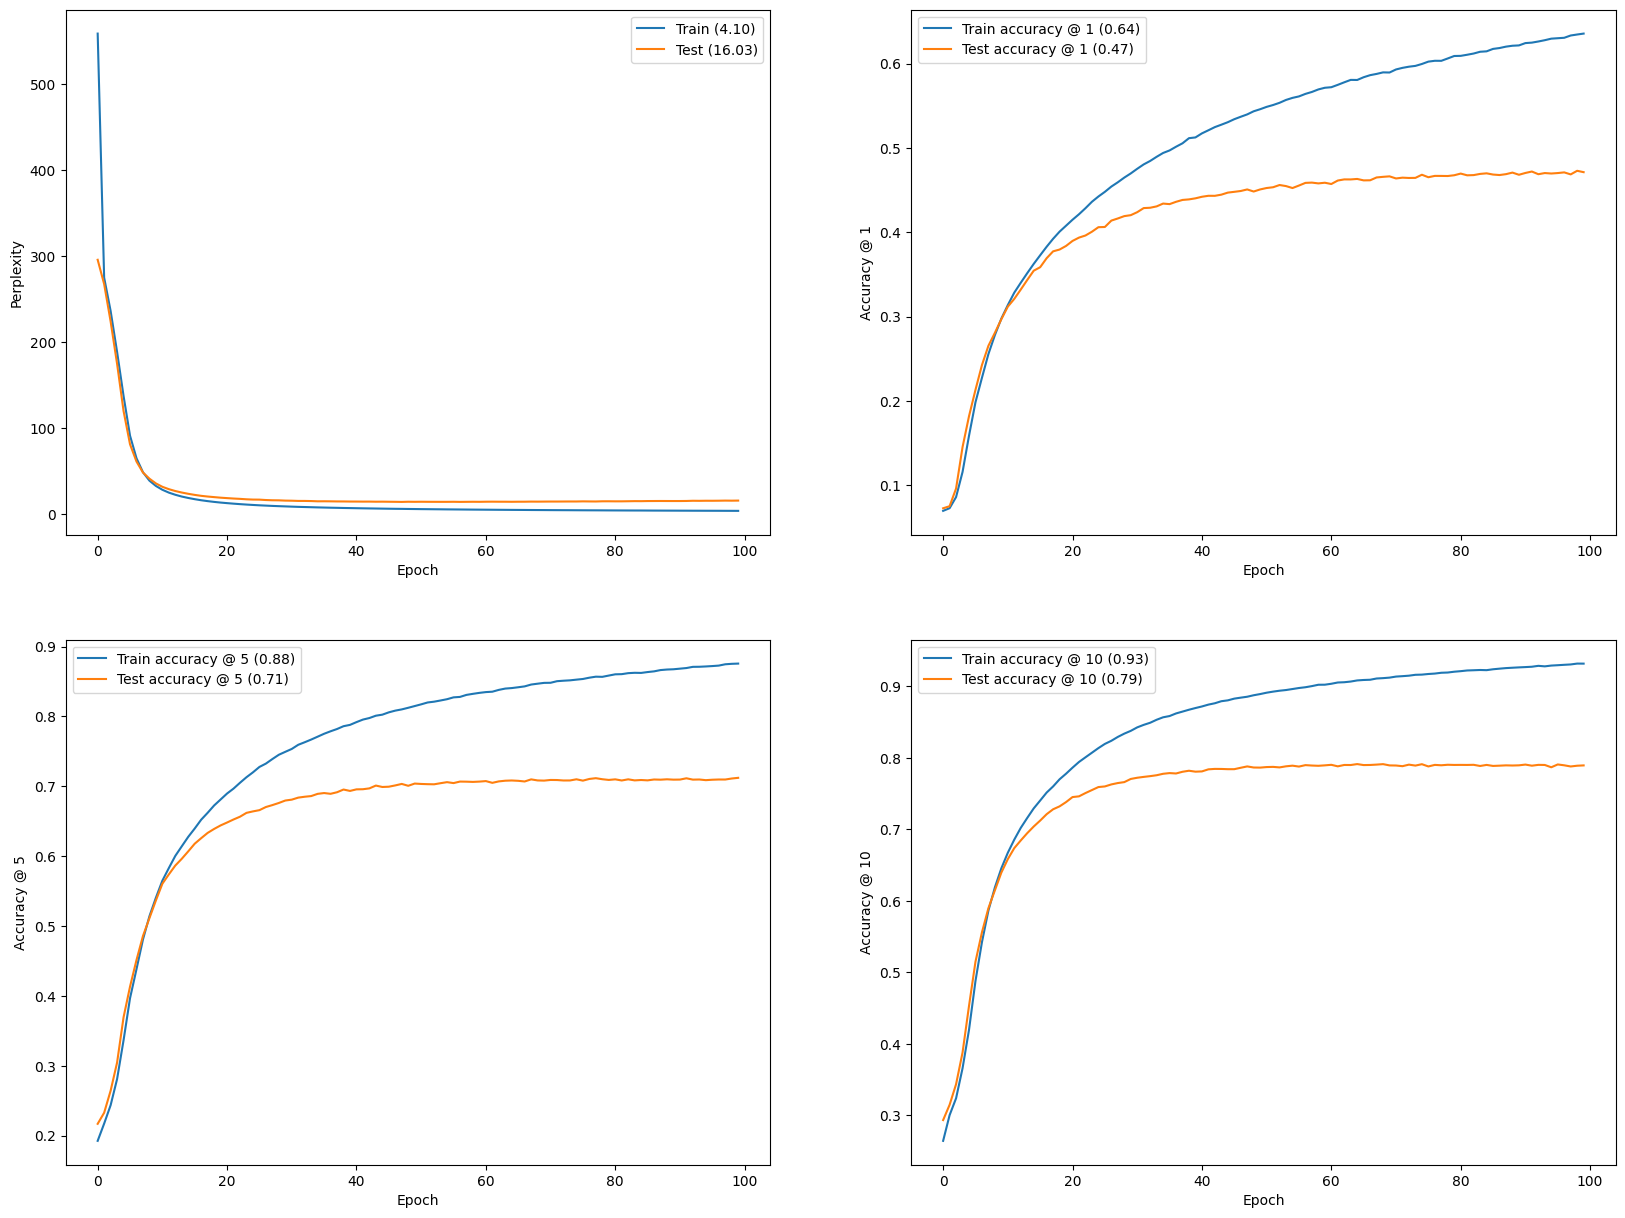

In [ ]:
# read training data
train_data = RNNData(train_df, vocab, length, prepad=False)
train_iter = DataLoader(train_data, batch_size, shuffle=True, drop_last=True)

# read test data
test_data = RNNData(test_df, vocab, length, prepad=False)
test_iter = DataLoader(test_data, batch_size, shuffle=True, drop_last=True)

lr = 1e-3
# create model
net = RNN(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

# Graph embedding
Using the premade FastRP embeddings for the labels. The embedding dimension providing the best results on the text data is used for embedding the graph. Surprisingly, the results are not improved by the graph embeddings.

8.23 seconds per epoch on cuda


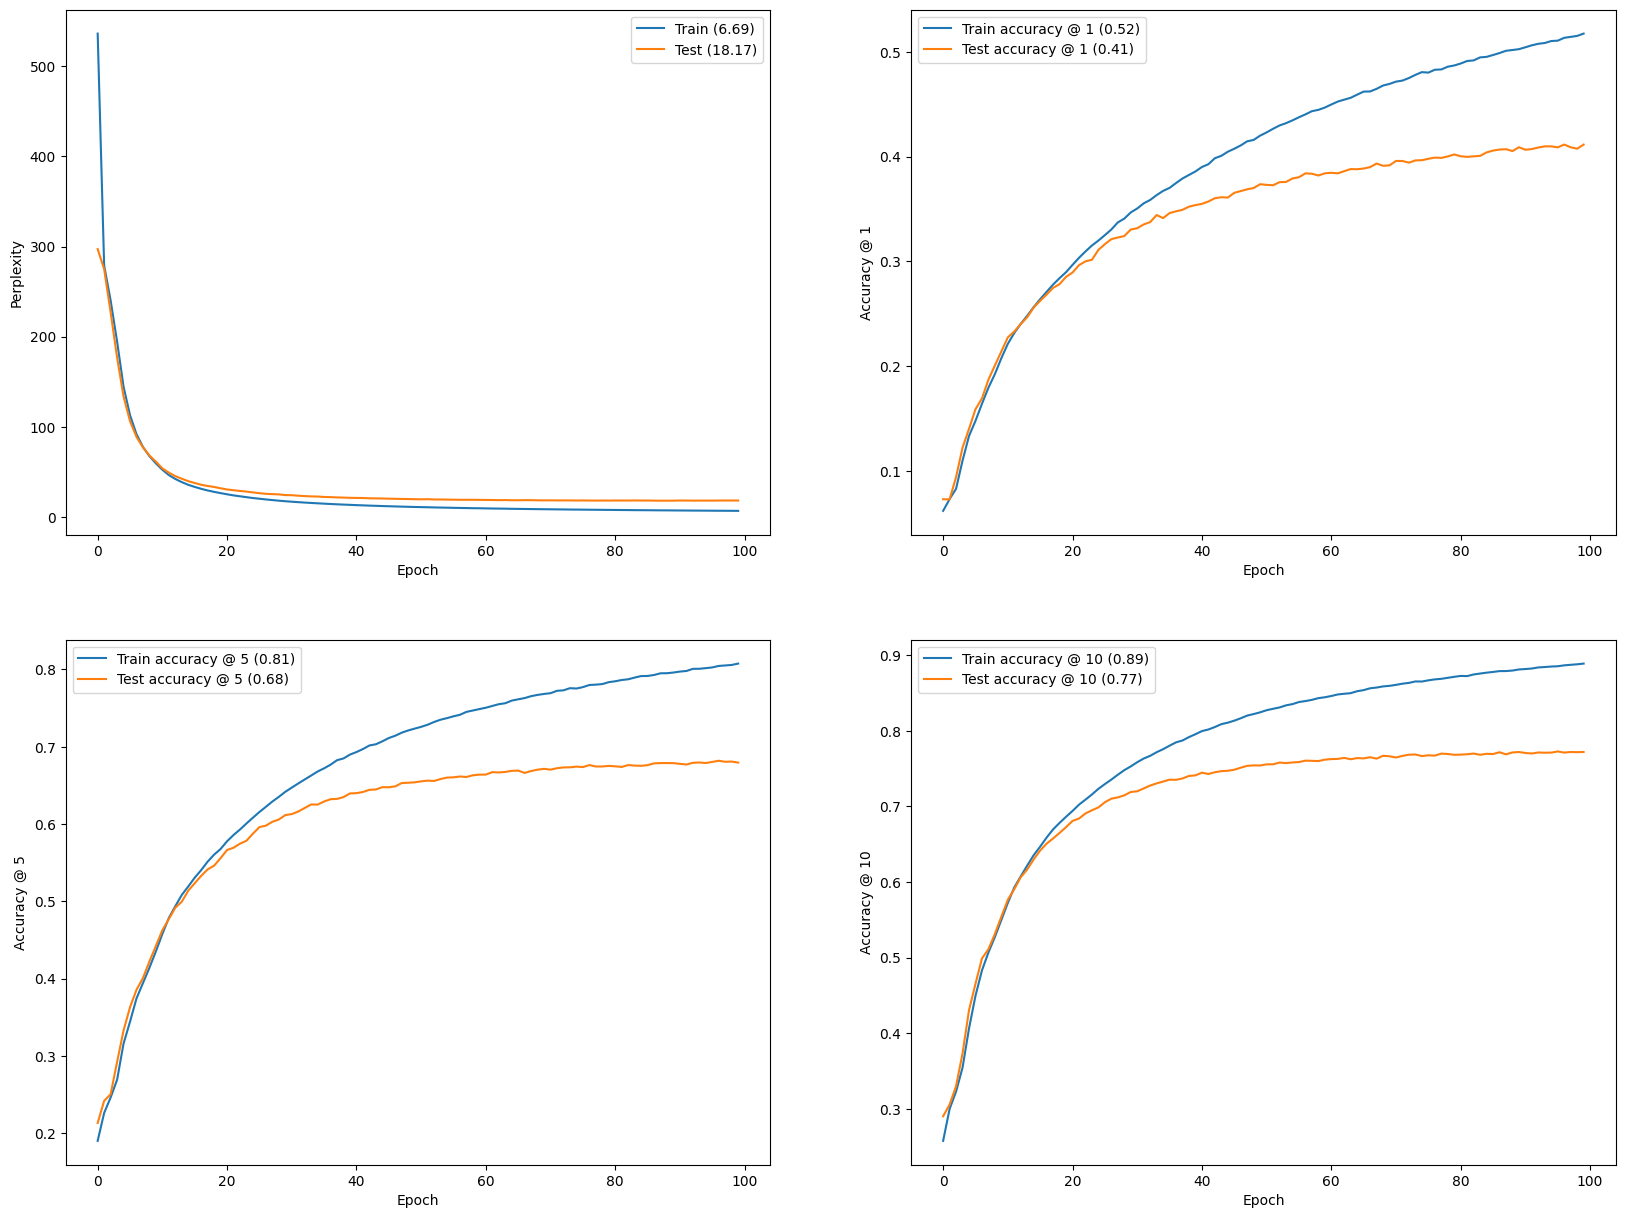

In [ ]:
lr = 1e-3
# create model
net = RNN(vocab, num_hiddens=128, embed_weights=True)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

# Activation
Test best model architecture with activation.

In [ ]:
class ReLUModel(RNN):
    """
    Neural net with ReLU activation.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = torch.nn.ReLU()

    def forward(self, inputs, state):
        X = self.embedding(inputs) # embed ingredients
        Y, state = self.rnn(X, state) # make prediction
        y = Y[:, -1] # get final prediction (missing ingredient)
        output = self.activation(self.fc(y))
        return output, state

8.68 seconds per epoch on cuda


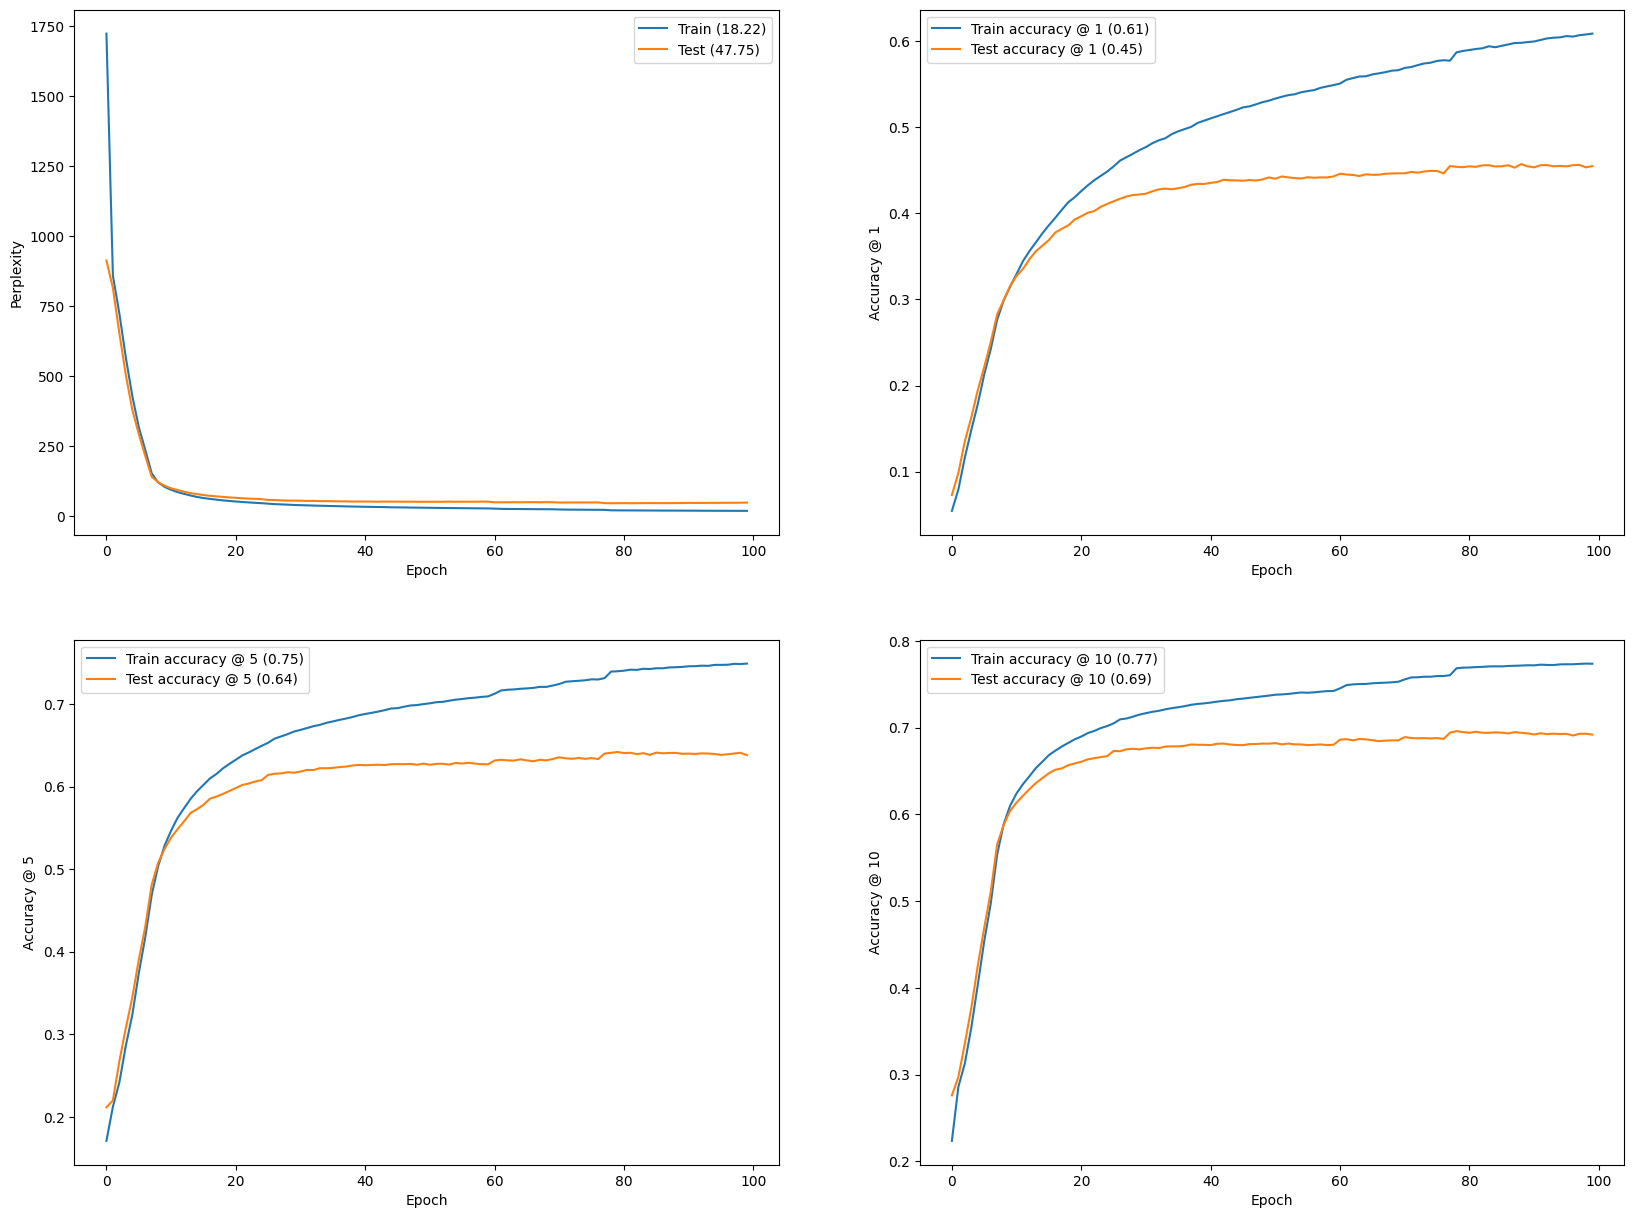

In [ ]:
# train model
net = ReLUModel(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

In [ ]:
class SoftMaxModel(RNN):
    """
    Neural net with ReLU activation.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = torch.nn.Softmax(dim=1)

    def forward(self, inputs, state):
        X = self.embedding(inputs) # embed ingredients
        Y, state = self.rnn(X, state) # make prediction
        y = Y[:, -1] # get final prediction (missing ingredient)
        output = self.activation(self.fc(y))
        return output, state

8.74 seconds per epoch on cuda


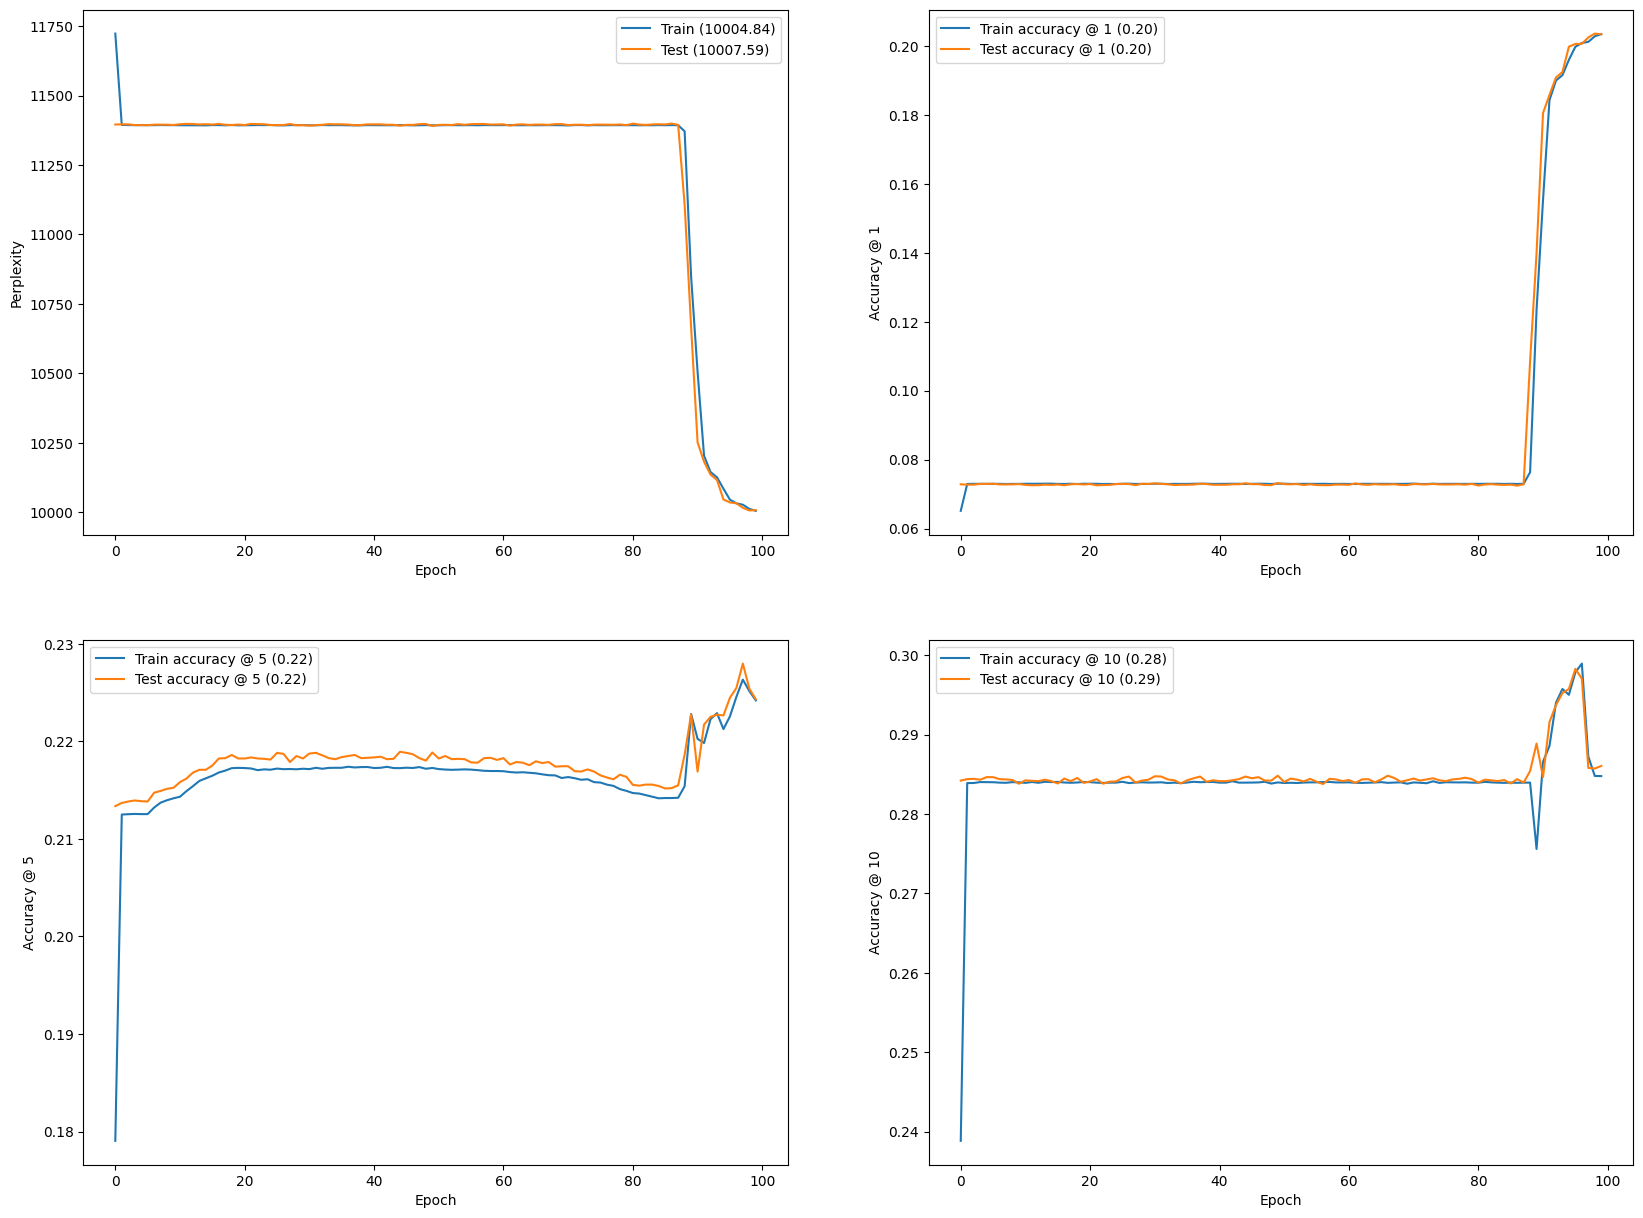

In [ ]:
# train model
net = SoftMaxModel(vocab, embed_dim=8, num_hiddens=128)
# train and test model
train, test = train(net, train_iter, test_iter, lr, num_epochs, device)
plot(train, test)

# Shuffling
Assess how shuffling affects results.

8.41 seconds per epoch on cuda


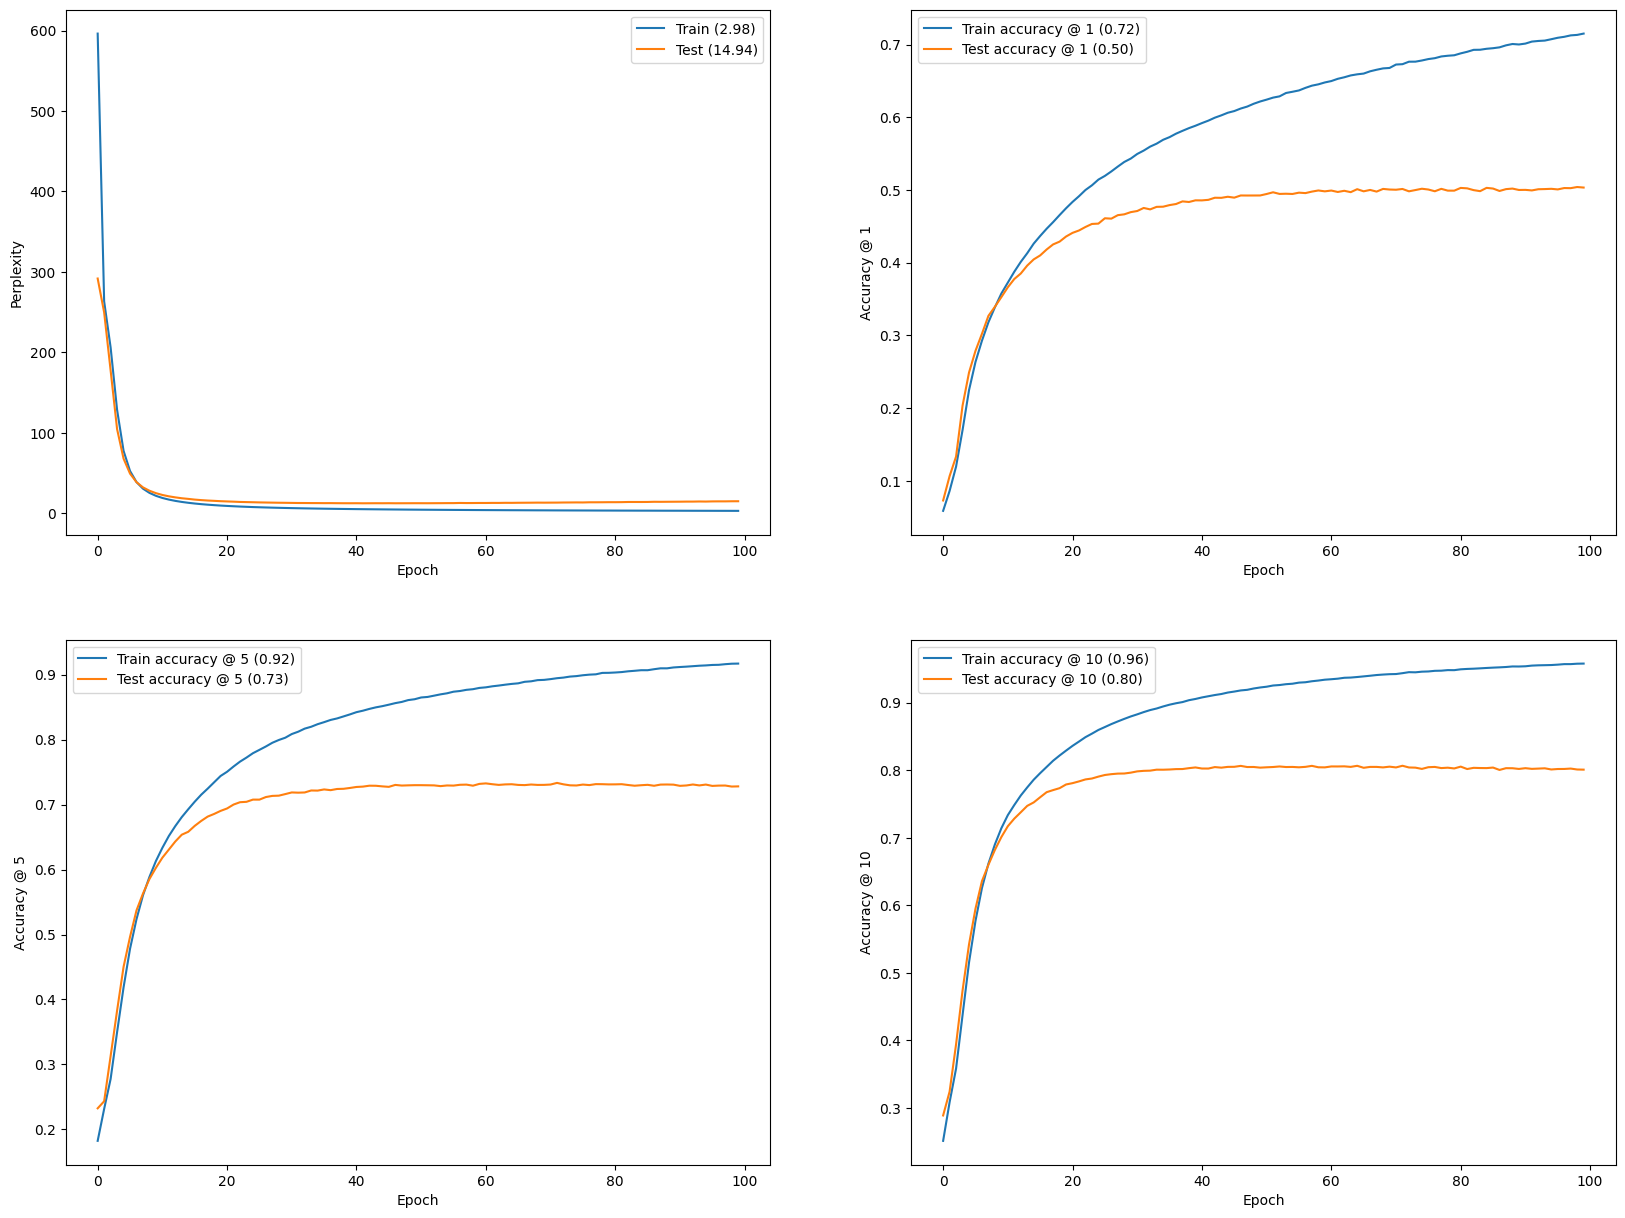

In [ ]:
# define class without shuffle
class NoShuffleData(RNNData):
    def __init__(self, df, vocab, max_length=None, prepad=True):
        # assign variables
        self.vocab = vocab
        self.max_length = max_length if max_length \
        else len(max(df['ingredients'], key=len))
        self.prepad = prepad
        # assign ingredients
        self.recipes = df['ingredients']

# set length to consider
length = 20
# split dataset
train_df, test_df = train_test_split(df, test_size=0.20, random_state = seed)
# read training data
train_data_noshuffle = NoShuffleData(train_df, vocab, length)
train_iter_noshuffle = DataLoader(train_data, batch_size, shuffle=True, drop_last=True)

# read test data, should be shuffled  to see performance of model
test_data_shuffle = RNNData(test_df, vocab, length)
test_iter_shuffle = DataLoader(test_data, batch_size, shuffle=True, drop_last=True)

# run model
net = RNN(vocab, embed_dim=8, num_hiddens=128)
train, test = train(net, train_iter_noshuffle, test_iter_shuffle, lr, 
                        num_epochs, device)

plot(train, test)